## 0. Некоторые организационные моменты (настройка окружения, seed)

In [587]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from scipy.stats import entropy
from pyod.models.iforest import IsolationForest
from pyod.models.ocsvm import OCSVM
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.neighbors import NearestNeighbors

In [588]:
seed = 5
np.random.seed(seed)

Сначала создаем виртуальное окружение

python -m venv my_venv

Теперь его активируем (для запуска эта же команда)

Если понадобится отключить - введите deactivate

my_venv\Scripts\activate

Если не выполняется, запустить следующую команду

Set-ExecutionPolicy RemoteSigned

Затем нажать Y и Enter. Теперь вы сможете выполнить активацию окружения

pip install -r requirements.txt

Переходим к самой задаче.

## 1. Данные в задаче

| № | Название                       | Описание                                                                                                                                   | Тип данных     |
|---|--------------------------------|--------------------------------------------------------------------------------------------------------------------------------------------|----------------|
| 1 | Вектор Мощи                    | Позиция магического механизма, управляющего интенсивностью перехода через портал.                                                          | Вещественный   |
| 2 | Скорость перехода через портал | Скорость, с которой портал перемещает объект через пространство.                                                                           | Вещественный   |
| 3 | Приток Силы Потока             | Поток магической силы, текущий через ядро портала, обеспечивая его стабильную работу.                                                      | Вещественный   |
| 4 | Ритм магического ядра          | Число оборотов магического ядра портала в минуту.                                                                                          | Вещественный   |
| 5 | Поток Энергий                  | Число оборотов генератора эфира, преобразующего внешнюю энергию в магическую.                                                              | Вещественный   |
| 6 | Сила Левого Потока             | Мощность магического потока, текущего через левую сторону портала, поддерживая его баланс.                                                 | Вещественный   |
| 7 | Сила Правого Потока            | Мощность магического потока, текущего через правую сторону портала, обеспечивая равномерное распределение энергии.                         | Вещественный   |
| 8 | Пламя Стихий                   | Температура магической энергии, исходящей из высокого магического источника портала, в градусах Цельсия.                                   | Вещественный   |
| 9 | Температура вдоха Истока       | Температура воздуха, входящего в магический ускоритель портала, в градусах Цельсия.                                                        | Вещественный   |
| 10| Температура выхода Истока      | Температура воздуха, исходящего из магического ускорителя портала, в градусах Цельсия.                                                     | Вещественный   |
| 11| Приток давления Выдоха Истока  | Давление магического потока на выходе из магического источника высокого давления.                                                          | Вещественный   |
| 12| Давление вдоха Истока          | Давление воздуха, входящего в магический ускоритель.                                                                                       | Вещественный   |
| 13| Давление выхода Истока         | Давление воздуха, исходящего из магического ускорителя.                                                                                    | Вещественный   |
| 14| Древний Ветер                  | Давление древней магической энергии, покидающей портал в виде выхлопного потока.                                                           | Вещественный   |
| 15| Печать Чародея                 | Параметр управления магическим впрыском в сердце портала, выраженный в процентах.                                                          | Вещественный   |
| 16| Эмульсия Истока                | Количество магического топлива, подпитывающего портал.                                                                                     | Вещественный   |
| 17| Дыхание Истока                 | Коэффициент, отображающий степень угасания магического ускорителя.                                                                         | Вещественный   |
| 18| Гармония Бессмертия            | Коэффициент, указывающий на состояние магического ядра портала и его стабильность, требующий магического восстановления в случае снижения. | Вещественный   |
| 19| Тип Вектора Мощи               | Метка типа позиции магического механизма                                                                                                   | Категориальный |
| 20| Номер пометки                  | Уникальный номер записи о работе портала в блокноте.                                                                                       | Целочисленный  |

Целевой признак - Гармония Бессмертия

Дополнительно:

Для определения общей мощности потоков сначала сложите значения **«Силы Левого Потока»** и **«Силы Правого Потока»**, чтобы получить представление о совокупной мощности. Для более полной картины суммарной силы всех потоков дополнительно объедините **«Силу Левого Потока»**, **«Силу Правого Потока»** и **«Приток Силы Потока»**.

Общую силу ядра можно оценить, умножив **«Ритм магического ядра»** на **«Приток Силы Потока»**, что даст показатель общей мощности ядра. Общее давление на выходе можно рассчитать, сложив значения **«Притока давления Выдоха Истока»** и **«Давления выхода Истока»**.

Магическую производительность определяет отношение **«Скорости перехода через портал»** к **«Эмульсии Истока»** — это покажет, насколько эффективно топливо поддерживает скорость перехода. Эффективность самого ядра можно вычислить, разделив его общую силу на **«Эмульсию Истока»**.

Для расчёта магической мощности потребуется учесть **«Эмульсию Истока»**, общее давление и разницу между **«Пламенем Стихий»** и **«Температурой вдоха Истока»**. (Использовать нельзя - Температура вдоха Истока уберется из-за огромного количества отсутствующий значений)

Оценить степень износа магических источников поможет отношение **«Дыхания Истока»** к **«Гармонии Бессмертия»**. (Использовать нельзя - утечка данных)

Абсолютное значение разницы между **«Дыханием Истока»** и **«Гармонией Бессмертия»** отразит расхождения в стабильности магии, а баланс угасания можно определить, разделив разницу между **«Дыханием Истока»** и **«Гармонией Бессмертия»** на **«Скорость перехода через портал»**. (Нельзя использовать - утечка данных)

Теперь загрузим датасет.

Важно!!!!! Данный датасет использует кодировку Windows 1251, а не UTF-8!!!

## 2.1 Загрузка данных из датасета

In [589]:
df = pd.read_csv('portal_data.csv', encoding='cp1251', sep='|')

In [590]:
df

,Вектор Мощи,Скорость перехода через портал,Приток Силы Потока,Ритм магического ядра,Поток Энергий,Сила Левого Потока,Сила Правого Потока,Пламя Стихий,Температура вдоха Истока,Температура выдоха Истока,Приток давления Выдоха Истока,Давление вдоха Истока,Давление выдоха Истока,Древний Ветер,Печать Чародея,Эмульсия Истока,Дыхание Истока,Гармония Бессмертия,Тип Вектора Мощи,Номер пометки
0,1.138,1.54332,289.964,141.318158,6677.380,7.584,7.584,464.006,736,-,1.096,Не определено,5.947,-,7.137,0.082,0.95,0.975,Слабый,0
1,2.088,-,6960.180,144.111767,6828.469,28.204,28.204,635.401,736,581.658,1.331,1.394603,7.282,1.019,10.655,0.287,0.95,0.975,Слабый,1
2,3.144,4.6299600000000005,8379.229,145.220853,7111.811,60.358,60.358,606.002,736,-,1.389,Не определено,7.574,-,13.086,0.259,0.95,0.975,Ниже среднего,2
3,4.161,6.17328,14724.395,162.050156,7792.630,113.774,113.774,661.471,736,-,1.658,Не определено,9.007,-,18.109,0.358,0.95,0.975,Ниже среднего,3
4,5.140,7.7166,21636.432,201.513586,8494.777,175.306,175.306,731.494,736,645.642,2.078,Не определено,11.197,1.026,26.373,0.522,0.95,0.975,Выше среднего,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11929,5.140,7.7166,21624.934,201.516623,8470.013,175.239,175.239,681.658,736,628.95,2.087,Не определено,10.990,1.027,23.803,0.471,1.00,1.000,Выше среднего,11929
11930,6.175,9.25992,29763.213,241.561772,8800.352,245.954,245.954,747.405,736,-,2.512,Не определено,13.109,-,32.671,0.647,1.00,1.000,Выше среднего,11930
11931,7.148,10.80324,39003.867,280.444950,9120.889,332.389,332.389,796.457,736,680.393,2.982,Не определено,15.420,1.036,42.104,0.834,1.00,1.000,Сильный,11931
11932,8.206,12.34656,50992.579,323.315332,9300.274,438.024,438.024,892.945,736,-,3.594,Не определено,18.293,-,58.064,1.149,1.00,1.000,Сильный,11932


## 2.2 Анализ данных в датасете

Теперь посмотрим типы данных (которые исходные)

In [591]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11934 entries, 0 to 11933
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Вектор Мощи                     11934 non-null  float64
 1   Скорость перехода через портал  11934 non-null  object 
 2   Приток Силы Потока              11934 non-null  float64
 3   Ритм магического ядра           11934 non-null  float64
 4   Поток Энергий                   11934 non-null  float64
 5   Сила Левого Потока              11934 non-null  float64
 6   Сила Правого Потока             11934 non-null  float64
 7   Пламя Стихий                    11934 non-null  float64
 8   Температура вдоха Истока        11934 non-null  int64  
 9   Температура выдоха Истока       11934 non-null  object 
 10  Приток давления Выдоха Истока   11934 non-null  float64
 11  Давление вдоха Истока           11934 non-null  object 
 12  Давление выдоха Истока          

In [592]:
df.describe()

,Вектор Мощи,Приток Силы Потока,Ритм магического ядра,Поток Энергий,Сила Левого Потока,Сила Правого Потока,Пламя Стихий,Температура вдоха Истока,Приток давления Выдоха Истока,Давление выдоха Истока,Печать Чародея,Эмульсия Истока,Дыхание Истока,Гармония Бессмертия,Номер пометки
count,11934.000000,11934.000000,11934.000000,11934.000000,11934.000000,11934.000000,11934.000000,11934.0,11934.000000,11934.000000,11934.000000,11934.000000,11934.00000,11934.0000,11934.000000
mean,5.166667,27247.498685,223.711688,8200.947312,227.335768,227.335768,735.495446,736.0,2.352963,12.297123,33.641261,0.662440,0.97500,0.9875,5966.500000
std,2.626388,22148.613155,81.061874,1091.315507,200.495889,200.495889,173.680552,0.0,1.084770,5.337448,25.841363,0.507132,0.01472,0.0075,3445.193391
min,1.138000,253.547000,136.939406,6589.002000,5.304000,5.304000,442.364000,736.0,1.093000,5.828000,0.000000,0.068000,0.95000,0.9750,0.000000
25%,3.144000,8375.883750,145.220958,7058.324000,60.317000,60.317000,589.872750,736.0,1.389000,7.447250,13.677500,0.246000,0.96200,0.9810,2983.250000
50%,5.140000,21630.659000,201.514947,8482.081500,175.268000,175.268000,706.038000,736.0,2.083000,11.092000,25.276500,0.496000,0.97500,0.9875,5966.500000
75%,7.148000,39001.426750,280.447777,9132.606000,332.364750,332.364750,834.066250,736.0,2.981000,15.658000,44.552500,0.882000,0.98800,0.9940,8949.750000
max,9.300000,72784.872000,372.879926,9797.103000,645.249000,645.249000,1115.797000,736.0,4.560000,23.140000,92.556000,1.832000,1.00000,1.0000,11933.000000


Заметим, что признаков в describe 15, а не 20 (изначально)

In [593]:
set(df.columns).symmetric_difference(df.describe().columns)

{'Давление вдоха Истока',
 'Древний Ветер',
 'Скорость перехода через портал',
 'Температура выдоха Истока',
 'Тип Вектора Мощи'}

То есть у этих признаков может и не быть числовых значений вообще (не обязательно).

In [594]:
df['Давление вдоха Истока'].unique()

array(['Не определено', '1.394603'], dtype=object)

In [595]:
len(df[df['Давление вдоха Истока'] != 'Не определено']) / len(df)

0.20437405731523378

Около 20,4 % обладают одним и тем же Давление вдоха Истока, а остальные вообще не обладают данным признаком. Целесообразно просто **удалить** данный признак!

In [596]:
df['Древний Ветер'].unique()

array(['-', '1.019', '1.026', '1.03', '1.02', '1.04', '1.022', '1.035',
       '1.049', '1.041', '1.023', '1.05', '1.036', '1.042', '1.031',
       '1.027', '1.051', '1.021', '1.052', '1.043'], dtype=object)

In [597]:
len(df[df['Древний Ветер'] == '-']) / len(df)

0.7999832411597118

Видим, что и у параметра **Древний ветер** похожая проблема. Поэтому, чтобы не захломлять и так большое количество параметров - **УДАЛИМ** его!

In [598]:
df['Скорость перехода через портал'].unique()

array(['1.54332', '-', '4.6299600000000005', '6.17328', '7.7166',
       '9.25992', '10.80324', '12.34656', '13.88988', '3.08664'],
      dtype=object)

In [599]:
len(df[df['Скорость перехода через портал'] == '-']) / len(df)

0.1008044243338361

In [600]:
print(df['Скорость перехода через портал'].value_counts(dropna=False))

Скорость перехода через портал
12.34656              1204
-                     1203
1.54332               1202
7.7166                1200
13.88988              1199
3.08664               1199
9.25992               1187
10.80324              1186
6.17328               1180
4.6299600000000005    1174
Name: count, dtype: int64


Убирать данный признак не будем. Просто заполним значения '-' медианой. **Изменено: мы посмотрим на гистограмме как это влияет на распределение**

Перед тем как определять, чем же заполнить "Скорость перехода через портал" - выполним все остальные действия, не зависящие от этого признака.

In [601]:
df['Температура выдоха Истока'].unique()

array(['-', '581.658', '645.642', ..., '680.557', '628.95', '680.393'],
      shape=(2369,), dtype=object)

In [602]:
len(df[df['Температура выдоха Истока'] == '-']) / len(df)

0.7999832411597118

Очень много пропущенных значений. Признак удаляем

In [603]:
df['Тип Вектора Мощи'].unique()

array(['Слабый', 'Ниже среднего', 'Выше среднего', 'Сильный'],
      dtype=object)

Тут явный категориальный признак - используем hot-encoding

Подытожим:

**Номер пометки** - является ID - удаляем;

**Давление вдоха Истока** - ОЧЕНЬ много пустых значений - удаляем;

**Древний Ветер** - ОЧЕНЬ много пустых значений - удаляем;

**Температура выдоха Истока** - ОЧЕНЬ много пустых значений - удаляем;

Конечно, преобразуем другие типы данных чтобы датасет не занимал так много места.

Параметры, полученные из других просто добавим в новый датасет. Убирать исходные признаки (участвовашие в формулах) пока что не будем.

## 2.3 Удаление ненужных столбцов, приведение типов, перепроверка

In [604]:
new_df = df

In [605]:
new_df.columns

Index(['Вектор Мощи', 'Скорость перехода через портал', 'Приток Силы Потока',
       'Ритм магического ядра', 'Поток Энергий', 'Сила Левого Потока',
       'Сила Правого Потока', 'Пламя Стихий', 'Температура вдоха Истока',
       'Температура выдоха Истока', 'Приток давления Выдоха Истока',
       'Давление вдоха Истока', 'Давление выдоха Истока', 'Древний Ветер',
       'Печать Чародея', 'Эмульсия Истока', 'Дыхание Истока',
       'Гармония Бессмертия', 'Тип Вектора Мощи', 'Номер пометки'],
      dtype='object')

In [606]:
new_df.drop(columns=['Номер пометки','Давление вдоха Истока','Древний Ветер','Температура выдоха Истока'], inplace=True)

Уберем все пустые значения (если есть)

In [607]:
for col in new_df.columns:
    print(f"{new_df[col].unique()} для столбца {col}")

[1.138 2.088 3.144 4.161 5.14  6.175 7.148 8.206 9.3  ] для столбца Вектор Мощи
['1.54332' '-' '4.6299600000000005' '6.17328' '7.7166' '9.25992'
 '10.80324' '12.34656' '13.88988' '3.08664'] для столбца Скорость перехода через портал
[  289.964  6960.18   8379.229 ... 39003.867 50992.579 72775.13 ] для столбца Приток Силы Потока
[141.31815762 144.11176652 145.22085345 ... 140.80806769 147.29891227
 140.89425205] для столбца Ритм магического ядра
[6677.38  6828.469 7111.811 ... 9120.889 9300.274 9742.95 ] для столбца Поток Энергий
[ 7.584 28.204 60.358 ... 22.335 10.692 22.478] для столбца Сила Левого Потока
[ 7.584 28.204 60.358 ... 22.335 10.692 22.478] для столбца Сила Правого Потока
[ 464.006  635.401  606.002 ...  796.457  892.945 1038.411] для столбца Пламя Стихий
[736] для столбца Температура вдоха Истока
[1.096 1.331 1.389 1.658 2.078 2.501 2.963 3.576 4.498 1.1   1.33  1.657
 3.575 4.496 1.117 2.962 3.574 4.495 1.142 1.326 2.5   2.961 4.494 1.163
 1.324 1.388 2.077 3.573 4.493 1

Замечаем, что Температура вдоха Истока - признак, в котором присутствует одно уникальное значение - удаляем признак!

In [608]:
new_df.drop(columns=['Температура вдоха Истока'], inplace=True)

In [609]:
new_df = new_df.replace(['-', '', 'N/A', 'Неизвестно', '<NA>', 'nan', '...'], pd.NA)

In [610]:
for col in new_df.columns:
    print(f"{(new_df[col].isnull().sum() / len(df)) * 100} для столбца {col}")

0.0 для столбца Вектор Мощи
10.08044243338361 для столбца Скорость перехода через портал
0.0 для столбца Приток Силы Потока
0.0 для столбца Ритм магического ядра
0.0 для столбца Поток Энергий
0.0 для столбца Сила Левого Потока
0.0 для столбца Сила Правого Потока
0.0 для столбца Пламя Стихий
0.0 для столбца Приток давления Выдоха Истока
0.0 для столбца Давление выдоха Истока
0.0 для столбца Печать Чародея
0.0 для столбца Эмульсия Истока
0.0 для столбца Дыхание Истока
0.0 для столбца Гармония Бессмертия
0.0 для столбца Тип Вектора Мощи


Для NaN значений в Скорости перехода воспользуемся простой медианой. (Перед этим представим признак числовым, так как сейчас он типа object)                                        **Проверим заполнение разными значениями**

In [611]:
new_df['Скорость перехода через портал'].unique()

array(['1.54332', <NA>, '4.6299600000000005', '6.17328', '7.7166',
       '9.25992', '10.80324', '12.34656', '13.88988', '3.08664'],
      dtype=object)

In [612]:
new_df['Скорость перехода через портал'] = pd.to_numeric(new_df['Скорость перехода через портал'], errors='coerce')

In [613]:
new_df = pd.get_dummies(new_df, columns=['Тип Вектора Мощи'], drop_first=True)

In [614]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11934 entries, 0 to 11933
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Вектор Мощи                     11934 non-null  float64
 1   Скорость перехода через портал  10731 non-null  float64
 2   Приток Силы Потока              11934 non-null  float64
 3   Ритм магического ядра           11934 non-null  float64
 4   Поток Энергий                   11934 non-null  float64
 5   Сила Левого Потока              11934 non-null  float64
 6   Сила Правого Потока             11934 non-null  float64
 7   Пламя Стихий                    11934 non-null  float64
 8   Приток давления Выдоха Истока   11934 non-null  float64
 9   Давление выдоха Истока          11934 non-null  float64
 10  Печать Чародея                  11934 non-null  float64
 11  Эмульсия Истока                 11934 non-null  float64
 12  Дыхание Истока                  

In [615]:
for i in new_df.columns:
    print(new_df[i].describe())

count    11934.000000
mean         5.166667
std          2.626388
min          1.138000
25%          3.144000
50%          5.140000
75%          7.148000
max          9.300000
Name: Вектор Мощи, dtype: float64
count    10731.000000
mean         7.721490
std          3.993642
min          1.543320
25%          4.629960
50%          7.716600
75%         10.803240
max         13.889880
Name: Скорость перехода через портал, dtype: float64
count    11934.000000
mean     27247.498685
std      22148.613155
min        253.547000
25%       8375.883750
50%      21630.659000
75%      39001.426750
max      72784.872000
Name: Приток Силы Потока, dtype: float64
count    11934.000000
mean       223.711688
std         81.061874
min        136.939406
25%        145.220958
50%        201.514947
75%        280.447777
max        372.879926
Name: Ритм магического ядра, dtype: float64
count    11934.000000
mean      8200.947312
std       1091.315507
min       6589.002000
25%       7058.324000
50%       8482

In [616]:
for i in [x for x in new_df.columns if x not in ['Приток Силы Потока','Тип Вектора Мощи_Ниже среднего','Тип Вектора Мощи_Сильный','Тип Вектора Мощи_Слабый']]:
    new_df[i] = new_df[i].astype('float32')

In [617]:
new_df['Приток Силы Потока'] = new_df['Приток Силы Потока'].astype('float32')

In [618]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11934 entries, 0 to 11933
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Вектор Мощи                     11934 non-null  float32
 1   Скорость перехода через портал  10731 non-null  float32
 2   Приток Силы Потока              11934 non-null  float32
 3   Ритм магического ядра           11934 non-null  float32
 4   Поток Энергий                   11934 non-null  float32
 5   Сила Левого Потока              11934 non-null  float32
 6   Сила Правого Потока             11934 non-null  float32
 7   Пламя Стихий                    11934 non-null  float32
 8   Приток давления Выдоха Истока   11934 non-null  float32
 9   Давление выдоха Истока          11934 non-null  float32
 10  Печать Чародея                  11934 non-null  float32
 11  Эмульсия Истока                 11934 non-null  float32
 12  Дыхание Истока                  

In [619]:
new_df['Приток Силы Потока'].isna().sum()

np.int64(0)

In [620]:
new_df['Приток Силы Потока'].isin([np.inf, -np.inf]).any()

np.False_

In [621]:
new_df['Общая мощность потоков'] = new_df['Сила Правого Потока'] + new_df['Сила Левого Потока']
new_df['Полная мощность потоков'] = new_df['Сила Правого Потока'] + new_df['Сила Левого Потока'] + new_df['Приток Силы Потока']
new_df['Общая сила Ядра'] = new_df['Ритм магического ядра'] * new_df['Приток Силы Потока']
new_df['Общее давление на выходе'] = new_df['Приток давления Выдоха Истока'] + new_df['Давление выдоха Истока']
# new_df['Магическая производительность'] = new_df['Скорость перехода через портал'] / new_df['Эмульсия Истока']
new_df['Эффективность Ядра'] = new_df['Общая сила Ядра'] / new_df['Эмульсия Истока']

In [622]:
for i in ['Общая мощность потоков', 'Полная мощность потоков','Общая сила Ядра', 'Общее давление на выходе', 'Эффективность Ядра']:
    print(new_df[i].describe())

count    11934.000000
mean       454.671539
std        400.991791
min         10.608000
25%        120.634003
50%        350.536011
75%        664.729492
max       1290.498047
Name: Общая мощность потоков, dtype: float64
count    11934.000000
mean     27702.169922
std      22549.281250
min        267.546997
25%       8496.517090
50%      21981.202148
75%      39666.143555
max      74075.289062
Name: Полная мощность потоков, dtype: float64
count    1.193400e+04
mean     7.872392e+06
std      8.488915e+06
min      3.556916e+04
25%      1.216337e+06
50%      4.358900e+06
75%      1.093774e+07
max      2.714001e+07
Name: Общая сила Ядра, dtype: float64
count    11934.000000
mean        14.650085
std          6.421679
min          6.924000
25%          8.837000
50%         13.175000
75%         18.635000
max         27.699999
Name: Общее давление на выходе, dtype: float64
count    1.193400e+04
mean     8.777893e+06
std      4.404463e+06
min      4.373923e+05
25%      4.924212e+06
50%      8

In [623]:
new_df['Общая мощность потоков'].isna().sum()

np.int64(0)

In [624]:
has_inf = new_df['Общая мощность потоков'].isin([np.inf, -np.inf]).any()
has_inf

np.False_

In [625]:
num_inf = new_df['Общая мощность потоков'].isin([np.inf, -np.inf]).sum()
print(f"Количество inf: {num_inf}")

Количество inf: 0


Напоминание**

Для определения общей мощности потоков сначала сложите значения **«Силы Левого Потока»** и **«Силы Правого Потока»**, чтобы получить представление о совокупной мощности. Для более полной картины суммарной силы всех потоков дополнительно объедините **«Силу Левого Потока»**, **«Силу Правого Потока»** и **«Приток Силы Потока»**.

Общую силу ядра можно оценить, умножив **«Ритм магического ядра»** на **«Приток Силы Потока»**, что даст показатель общей мощности ядра. Общее давление на выходе можно рассчитать, сложив значения **«Притока давления Выдоха Истока»** и **«Давления выхода Истока»**.

Магическую производительность определяет отношение **«Скорости перехода через портал»** к **«Эмульсии Истока»** — это покажет, насколько эффективно топливо поддерживает скорость перехода. Эффективность самого ядра можно вычислить, разделив его общую силу на **«Эмульсию Истока»**.

In [626]:
new_df['Общая мощность потоков'] = new_df['Общая мощность потоков'].astype('float32')
new_df['Полная мощность потоков'] = new_df['Полная мощность потоков'].astype('float32')
new_df['Общая сила Ядра'] = new_df['Общая сила Ядра'].astype('float64')
new_df['Общее давление на выходе'] = new_df['Общее давление на выходе'].astype('float32')
# new_df['Магическая производительность'] = new_df['Магическая производительность'].astype('float64')
new_df['Эффективность Ядра'] = new_df['Эффективность Ядра'].astype('float64')

In [627]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11934 entries, 0 to 11933
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Вектор Мощи                     11934 non-null  float32
 1   Скорость перехода через портал  10731 non-null  float32
 2   Приток Силы Потока              11934 non-null  float32
 3   Ритм магического ядра           11934 non-null  float32
 4   Поток Энергий                   11934 non-null  float32
 5   Сила Левого Потока              11934 non-null  float32
 6   Сила Правого Потока             11934 non-null  float32
 7   Пламя Стихий                    11934 non-null  float32
 8   Приток давления Выдоха Истока   11934 non-null  float32
 9   Давление выдоха Истока          11934 non-null  float32
 10  Печать Чародея                  11934 non-null  float32
 11  Эмульсия Истока                 11934 non-null  float32
 12  Дыхание Истока                  

## 3. Разделение данных на train и test

In [628]:
train_df, test_df = train_test_split(new_df, shuffle=True, random_state=seed, test_size=0.20)

X_train, X_test = train_df.drop(columns='Гармония Бессмертия'), test_df.drop(columns='Гармония Бессмертия')
y_train, y_test = train_df['Гармония Бессмертия'], test_df['Гармония Бессмертия']

In [629]:
X_train.head(20)

,Вектор Мощи,Скорость перехода через портал,Приток Силы Потока,Ритм магического ядра,Поток Энергий,Сила Левого Потока,Сила Правого Потока,Пламя Стихий,Приток давления Выдоха Истока,Давление выдоха Истока,...,Эмульсия Истока,Дыхание Истока,Тип Вектора Мощи_Ниже среднего,Тип Вектора Мощи_Сильный,Тип Вектора Мощи_Слабый,Общая мощность потоков,Полная мощность потоков,Общая сила Ядра,Общее давление на выходе,Эффективность Ядра
1996,8.206,12.34656,50996.140625,323.331451,9318.402344,438.010986,438.010986,933.244019,3.571,18.382999,...,1.205,0.958,False,True,False,876.021973,51872.164062,1.648866e+07,21.953999,13683531.00
11259,1.138,NaN,3446.263916,142.667679,6597.133789,8.212000,8.212000,546.807007,1.217,6.622000,...,0.191,0.998,False,False,True,16.424000,3462.687988,4.916705e+05,7.839000,2574191.00
5614,8.206,12.34656,50993.601562,323.322021,9314.871094,438.087006,438.087006,910.711975,3.573,18.193001,...,1.170,0.973,False,True,False,876.174011,51869.777344,1.648735e+07,21.766001,14091756.00
3604,5.140,7.71660,21633.392578,201.514847,8489.322266,175.306000,175.306000,713.585999,2.080,11.105000,...,0.504,0.965,False,False,False,350.612000,21984.003906,4.359450e+06,13.184999,8649702.00
7288,8.206,12.34656,50991.355469,323.307892,9301.239258,438.071014,438.071014,928.221985,3.596,18.674000,...,1.206,0.981,False,True,False,876.142029,51867.496094,1.648591e+07,22.270000,13669907.00
11258,9.300,NaN,72755.132812,372.839294,9724.115234,644.809021,644.809021,1060.384033,4.555,23.070999,...,1.754,0.998,False,True,False,1289.618042,74044.750000,2.712597e+07,27.625999,15465207.00
4864,5.140,7.71660,21633.439453,201.516312,8493.588867,175.283997,175.283997,701.424988,2.079,11.000000,...,0.490,0.970,False,False,False,350.567993,21984.007812,4.359491e+06,13.079000,8896920.00
2013,7.148,10.80324,38980.738281,280.447571,9135.990234,332.119995,332.119995,833.771973,2.960,15.449000,...,0.879,0.958,False,True,False,664.239990,39644.976562,1.093205e+07,18.409000,12436920.00
3283,8.206,12.34656,50994.031250,323.317230,9309.947266,437.980988,437.980988,942.711975,3.586,18.679001,...,1.225,0.964,False,True,False,875.961975,51869.992188,1.648725e+07,22.265001,13458979.00
4903,8.206,12.34656,50993.812500,323.322876,9316.123047,437.946991,437.946991,913.750000,3.571,18.202000,...,1.175,0.970,False,True,False,875.893982,51869.707031,1.648747e+07,21.772999,14031887.00


## 4. Обработка пропущенных значений

Будем пробовать находить верное значение на тестовой выборке

In [630]:
temp_df = X_train['Скорость перехода через портал']
temp_df.unique()

array([12.34656,      nan,  7.7166 , 10.80324,  6.17328,  1.54332,
        4.62996,  9.25992, 13.88988,  3.08664], dtype=float32)

<Axes: >

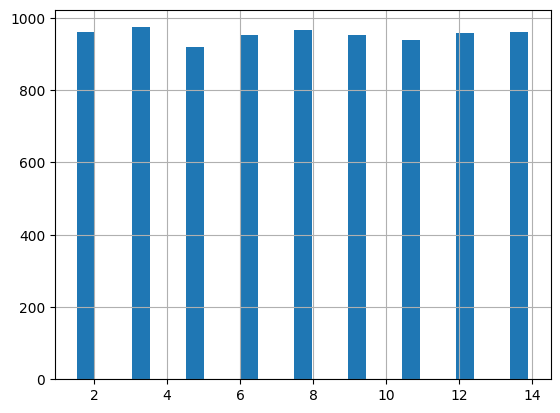

In [631]:
temp_df.hist(bins= 25)

In [632]:
temp_med = temp_df.fillna(temp_df.dropna(axis=0).median())

<Axes: >

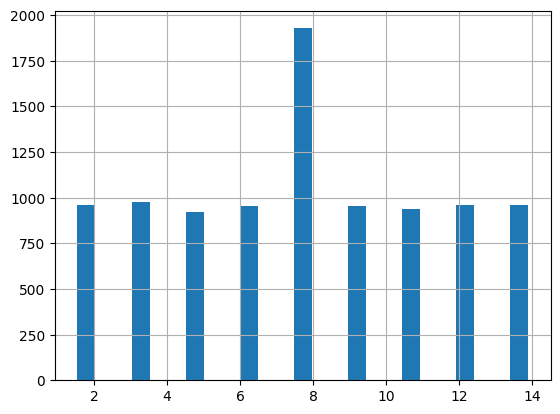

In [633]:
temp_med.hist(bins = 25)

Используем KL-дивергенцию с равномерным распределением

In [634]:
data1 = temp_med.dropna()
p1, _ = np.histogram(data1, bins=25, density=False)
p1 = p1 / p1.sum()
data2 = X_train['Скорость перехода через портал'].dropna()
p2, _ = np.histogram(data2, bins=25, density=False)
p2 = p2 / p2.sum()  
kl = entropy(p1, p2)  #  Сравниваем распределения
kl

np.float64(0.03335084383851507)

Распределения почти совпадают - хороший результат!

In [635]:
temp_mean = temp_df.fillna(temp_df.dropna(axis=0).mean())

<Axes: >

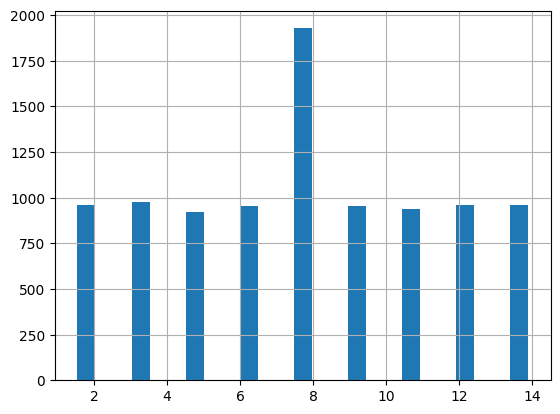

In [636]:
temp_mean.hist(bins = 25)

In [637]:
data1 = temp_mean.dropna()
p1, _ = np.histogram(data1, bins=25, density=False)
p1 = p1 / p1.sum()
data2 = X_train['Скорость перехода через портал'].dropna()
p2, _ = np.histogram(data2, bins=25, density=False)
p2 = p2 / p2.sum()  
kl = entropy(p1, p2)  #  Сравниваем распределения
kl

np.float64(0.03335084383851507)

Результат тот же самый => можно использовать любой (после проверки KNNImputer)

Воспользуемся KNNImputer (по некоторым столбцам пройдемся standardscaler)

In [638]:
df_temp = X_train.copy()

In [639]:
df_temp['Скорость перехода через портал'].unique()

array([12.34656,      nan,  7.7166 , 10.80324,  6.17328,  1.54332,
        4.62996,  9.25992, 13.88988,  3.08664], dtype=float32)

In [640]:
for col in ['Тип Вектора Мощи_Ниже среднего', 'Тип Вектора Мощи_Сильный', 'Тип Вектора Мощи_Слабый']:
    df_temp[col] = df_temp[col].astype(int)

In [641]:
df_temp = df_temp.fillna(df_temp.mean()) # заменяю на среднее чтобы масштабировать

In [642]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_temp)

In [643]:
imputer = KNNImputer(n_neighbors=5, weights='distance')
df_filled_scaled = imputer.fit_transform(df_scaled)

In [644]:
df_final = scaler.inverse_transform(df_filled_scaled)

In [645]:
df_result = pd.DataFrame(df_final, columns=df_temp.columns, index=df_temp.index)

<Axes: >

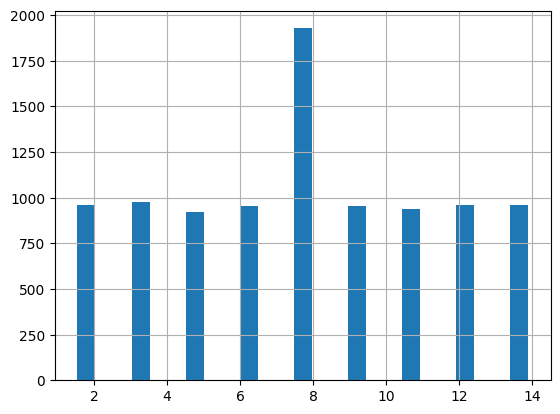

In [646]:
df_result['Скорость перехода через портал'].hist(bins = 25)

In [647]:
data1 = df_result['Скорость перехода через портал'].dropna()
p1, _ = np.histogram(data1, bins=25, density=False)
p1 = p1 / p1.sum()
data2 = X_train['Скорость перехода через портал'].dropna()
p2, _ = np.histogram(data2, bins=25, density=False)
p2 = p2 / p2.sum()  
kl = entropy(p1, p2)  #  Сравниваем распределения
kl

np.float64(0.03335084383851507)

Идентичный результат. Поэтому берём самый удобный и используем.

Лично я выбираю медианное значение, поскольку оно легче всего достается и является "классическим" решением в таких ситуациях.

In [648]:
replacer = X_train['Скорость перехода через портал'].median()

In [649]:
X_train['Скорость перехода через портал'] = X_train['Скорость перехода через портал'].fillna(replacer)

In [650]:
for col in X_train.columns:
    print(f"{(X_train[col].isnull().sum() / len(X_train)) * 100} для столбца {col}")

0.0 для столбца Вектор Мощи
0.0 для столбца Скорость перехода через портал
0.0 для столбца Приток Силы Потока
0.0 для столбца Ритм магического ядра
0.0 для столбца Поток Энергий
0.0 для столбца Сила Левого Потока
0.0 для столбца Сила Правого Потока
0.0 для столбца Пламя Стихий
0.0 для столбца Приток давления Выдоха Истока
0.0 для столбца Давление выдоха Истока
0.0 для столбца Печать Чародея
0.0 для столбца Эмульсия Истока
0.0 для столбца Дыхание Истока
0.0 для столбца Тип Вектора Мощи_Ниже среднего
0.0 для столбца Тип Вектора Мощи_Сильный
0.0 для столбца Тип Вектора Мощи_Слабый
0.0 для столбца Общая мощность потоков
0.0 для столбца Полная мощность потоков
0.0 для столбца Общая сила Ядра
0.0 для столбца Общее давление на выходе
0.0 для столбца Эффективность Ядра


In [651]:
X_test['Скорость перехода через портал'] = X_test['Скорость перехода через портал'].fillna(replacer)

In [652]:
for col in X_test.columns:
    print(f"{(X_test[col].isnull().sum() / len(X_test)) * 100} для столбца {col}")

0.0 для столбца Вектор Мощи
0.0 для столбца Скорость перехода через портал
0.0 для столбца Приток Силы Потока
0.0 для столбца Ритм магического ядра
0.0 для столбца Поток Энергий
0.0 для столбца Сила Левого Потока
0.0 для столбца Сила Правого Потока
0.0 для столбца Пламя Стихий
0.0 для столбца Приток давления Выдоха Истока
0.0 для столбца Давление выдоха Истока
0.0 для столбца Печать Чародея
0.0 для столбца Эмульсия Истока
0.0 для столбца Дыхание Истока
0.0 для столбца Тип Вектора Мощи_Ниже среднего
0.0 для столбца Тип Вектора Мощи_Сильный
0.0 для столбца Тип Вектора Мощи_Слабый
0.0 для столбца Общая мощность потоков
0.0 для столбца Полная мощность потоков
0.0 для столбца Общая сила Ядра
0.0 для столбца Общее давление на выходе
0.0 для столбца Эффективность Ядра


Теперь снова проверим типы

In [653]:
for col in ['Тип Вектора Мощи_Ниже среднего', 'Тип Вектора Мощи_Сильный', 'Тип Вектора Мощи_Слабый']:
    X_train[col] = X_train[col].astype('int16')
    X_test[col] = X_test[col].astype('int16')

In [654]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9547 entries, 1996 to 2915
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Вектор Мощи                     9547 non-null   float32
 1   Скорость перехода через портал  9547 non-null   float32
 2   Приток Силы Потока              9547 non-null   float32
 3   Ритм магического ядра           9547 non-null   float32
 4   Поток Энергий                   9547 non-null   float32
 5   Сила Левого Потока              9547 non-null   float32
 6   Сила Правого Потока             9547 non-null   float32
 7   Пламя Стихий                    9547 non-null   float32
 8   Приток давления Выдоха Истока   9547 non-null   float32
 9   Давление выдоха Истока          9547 non-null   float32
 10  Печать Чародея                  9547 non-null   float32
 11  Эмульсия Истока                 9547 non-null   float32
 12  Дыхание Истока                  9547

In [655]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2387 entries, 9078 to 4862
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Вектор Мощи                     2387 non-null   float32
 1   Скорость перехода через портал  2387 non-null   float32
 2   Приток Силы Потока              2387 non-null   float32
 3   Ритм магического ядра           2387 non-null   float32
 4   Поток Энергий                   2387 non-null   float32
 5   Сила Левого Потока              2387 non-null   float32
 6   Сила Правого Потока             2387 non-null   float32
 7   Пламя Стихий                    2387 non-null   float32
 8   Приток давления Выдоха Истока   2387 non-null   float32
 9   Давление выдоха Истока          2387 non-null   float32
 10  Печать Чародея                  2387 non-null   float32
 11  Эмульсия Истока                 2387 non-null   float32
 12  Дыхание Истока                  2387

## 5 Доработка параметров

In [656]:
X_test['Магическая производительность'] = X_test['Скорость перехода через портал'] / X_test['Эмульсия Истока']
X_train['Магическая производительность'] = X_train['Скорость перехода через портал'] / X_train['Эмульсия Истока']

In [657]:
X_test['Магическая производительность'] = X_test['Магическая производительность'].astype('float32')
X_train['Магическая производительность'] = X_train['Магическая производительность'].astype('float32')

In [658]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9547 entries, 1996 to 2915
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Вектор Мощи                     9547 non-null   float32
 1   Скорость перехода через портал  9547 non-null   float32
 2   Приток Силы Потока              9547 non-null   float32
 3   Ритм магического ядра           9547 non-null   float32
 4   Поток Энергий                   9547 non-null   float32
 5   Сила Левого Потока              9547 non-null   float32
 6   Сила Правого Потока             9547 non-null   float32
 7   Пламя Стихий                    9547 non-null   float32
 8   Приток давления Выдоха Истока   9547 non-null   float32
 9   Давление выдоха Истока          9547 non-null   float32
 10  Печать Чародея                  9547 non-null   float32
 11  Эмульсия Истока                 9547 non-null   float32
 12  Дыхание Истока                  9547

In [659]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2387 entries, 9078 to 4862
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Вектор Мощи                     2387 non-null   float32
 1   Скорость перехода через портал  2387 non-null   float32
 2   Приток Силы Потока              2387 non-null   float32
 3   Ритм магического ядра           2387 non-null   float32
 4   Поток Энергий                   2387 non-null   float32
 5   Сила Левого Потока              2387 non-null   float32
 6   Сила Правого Потока             2387 non-null   float32
 7   Пламя Стихий                    2387 non-null   float32
 8   Приток давления Выдоха Истока   2387 non-null   float32
 9   Давление выдоха Истока          2387 non-null   float32
 10  Печать Чародея                  2387 non-null   float32
 11  Эмульсия Истока                 2387 non-null   float32
 12  Дыхание Истока                  2387

## 6 Проверка наличия выбросов и аномалий в данных

In [660]:
combined_train_data = pd.concat([X_train, y_train], axis = 1)

In [661]:
exclude_cols = ['Гармония Бессмертия', 'Тип Вектора Мощи_Ниже среднего', 'Тип Вектора Мощи_Сильный', 'Тип Вектора Мощи_Слабый']

In [662]:
len(combined_train_data.columns)

23

In [663]:
cols_to_plot = combined_train_data.columns.difference(exclude_cols)

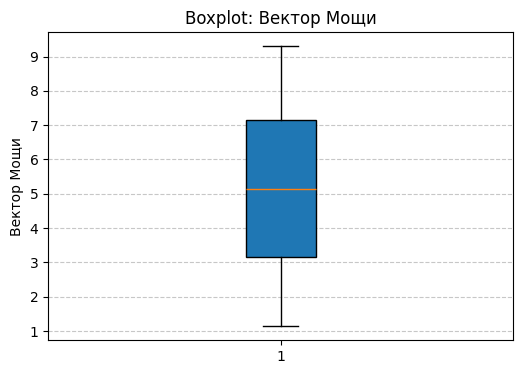

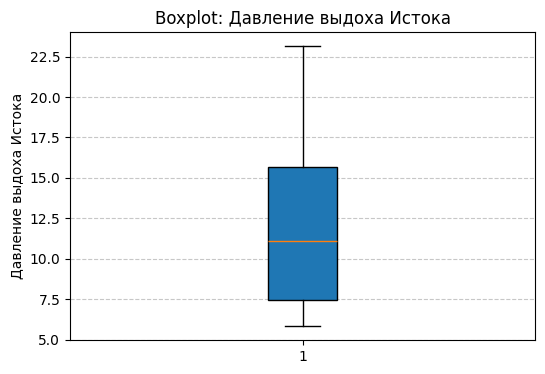

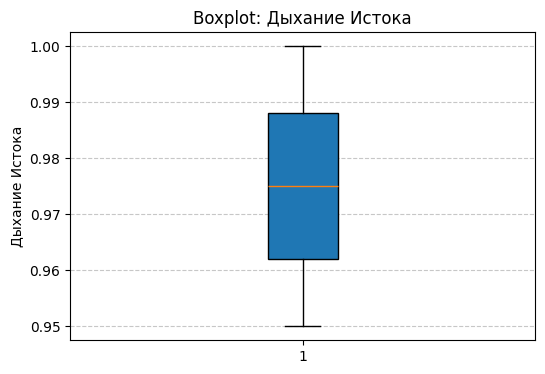

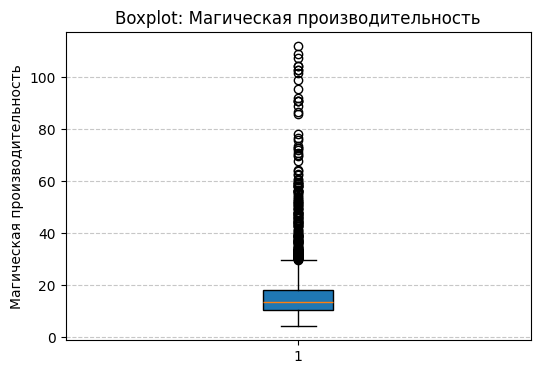

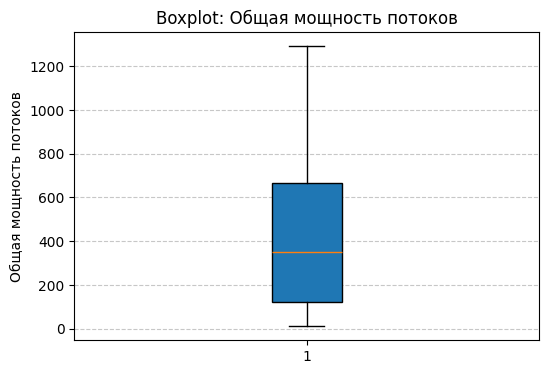

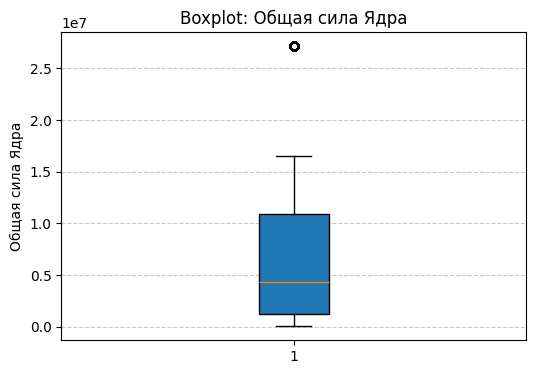

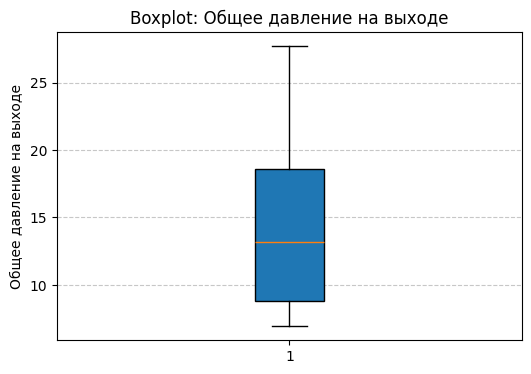

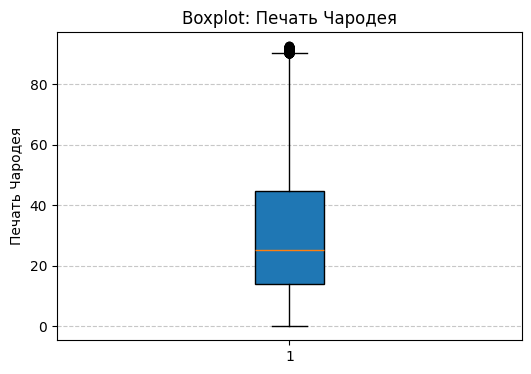

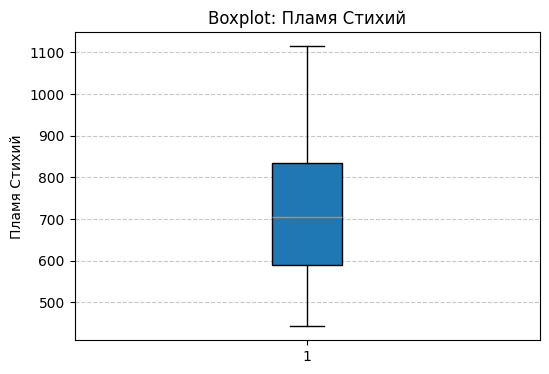

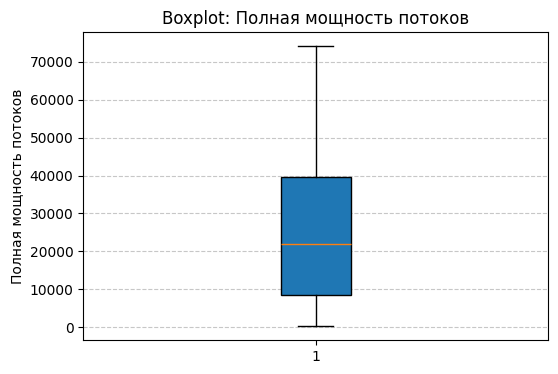

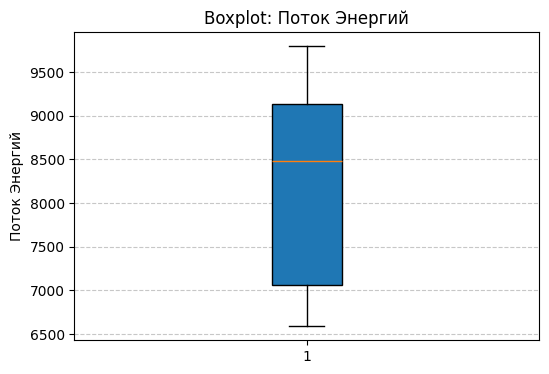

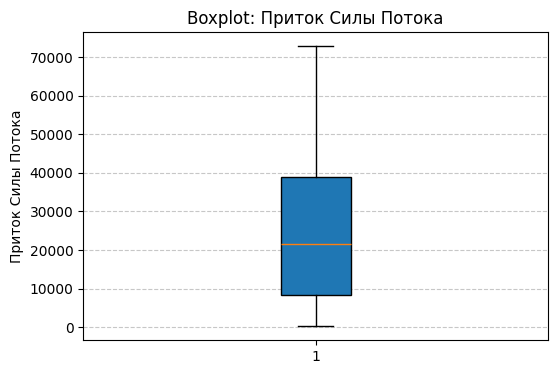

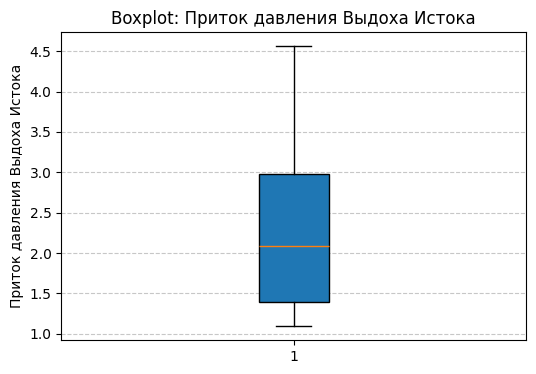

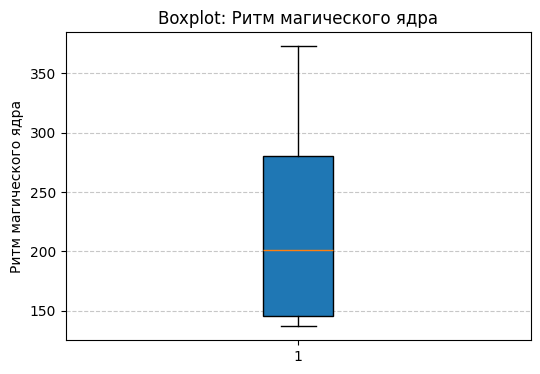

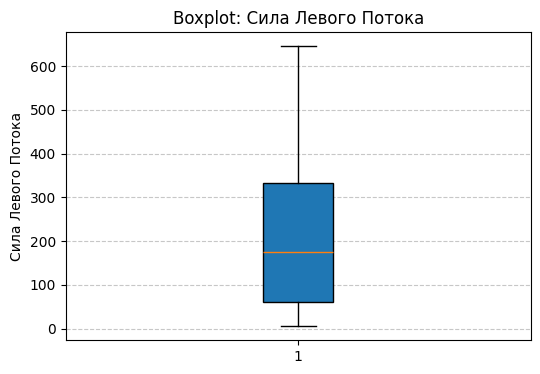

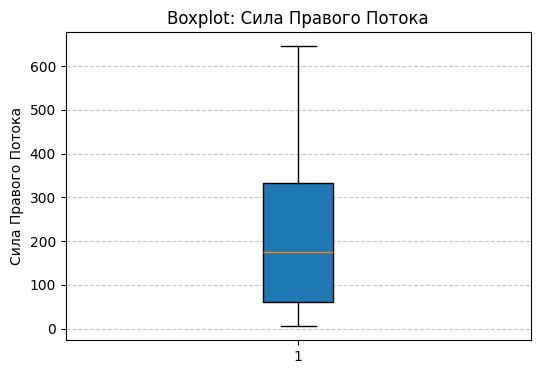

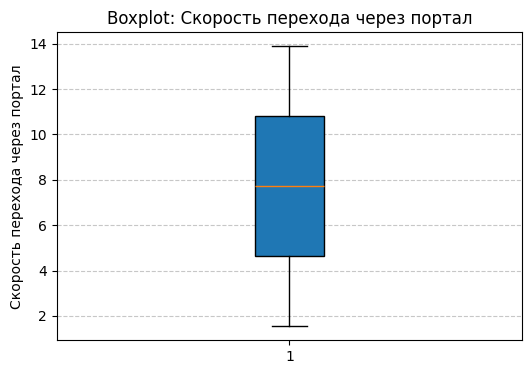

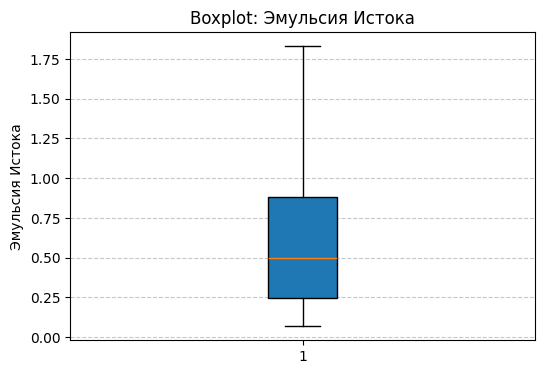

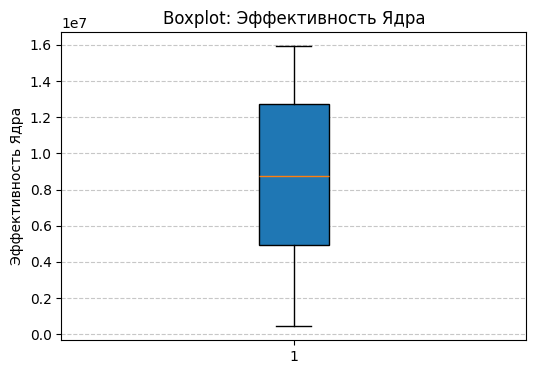

In [664]:
for col in cols_to_plot:
    plt.figure(figsize=(6, 4))
    plt.boxplot(combined_train_data[col].dropna(), vert=True, patch_artist=True)
    plt.title(f'Boxplot: {col}')
    plt.ylabel(col)
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.show()

Заметим, что особых смещений в данных нет (разве что незначительная в паре признаков - будем считать, что сильного влияния она не вносит). По поводу потенциальных выбросов - они есть. В признаках 'Печать Чародея', 'Общая сила Ядра', 'Магическая производительность' присутствуют возможные выбросы. Поэтому в них имеет смысл использовать IQR или Robust Z-score.

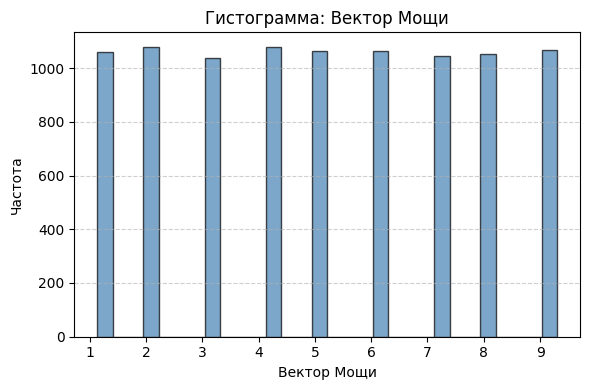

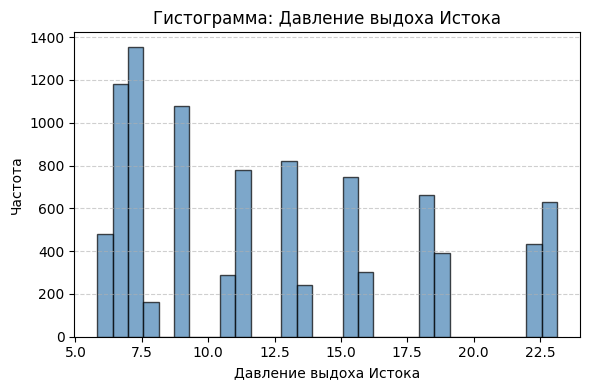

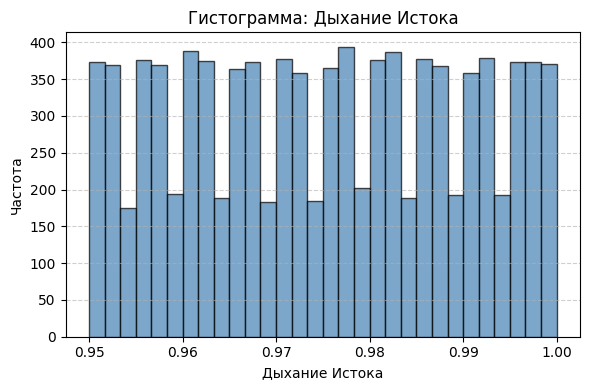

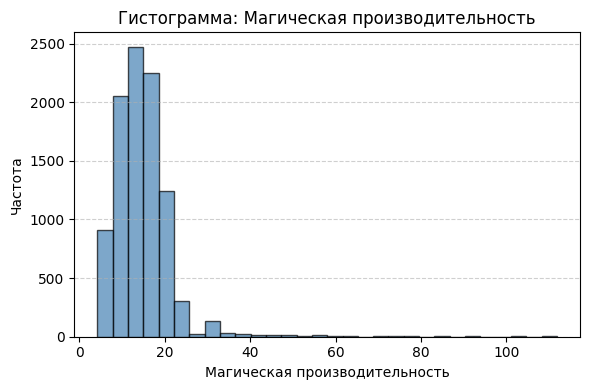

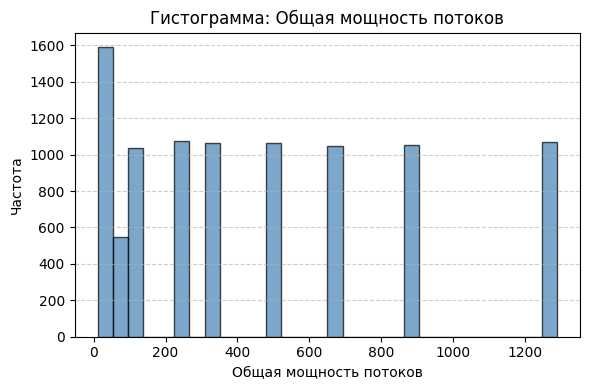

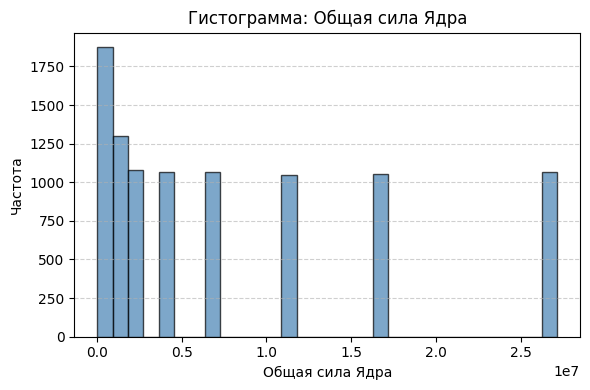

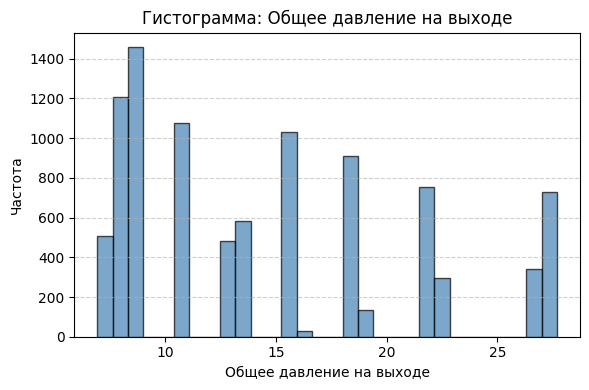

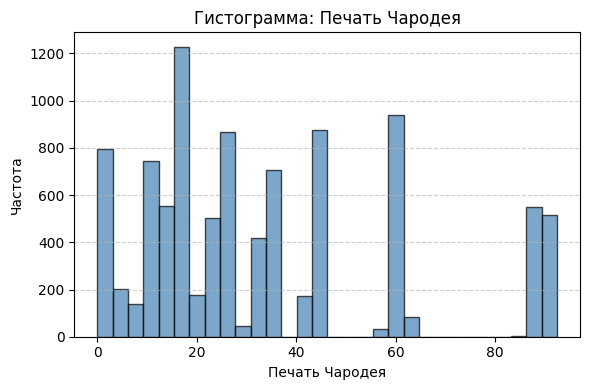

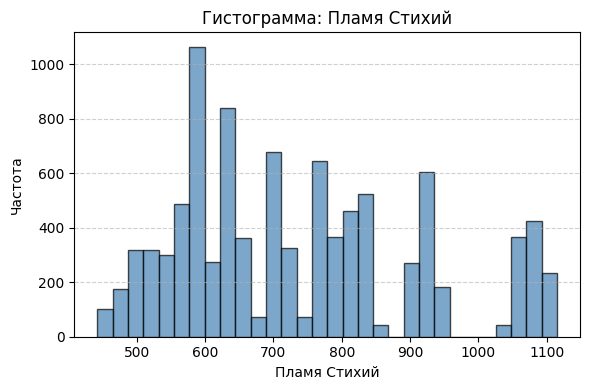

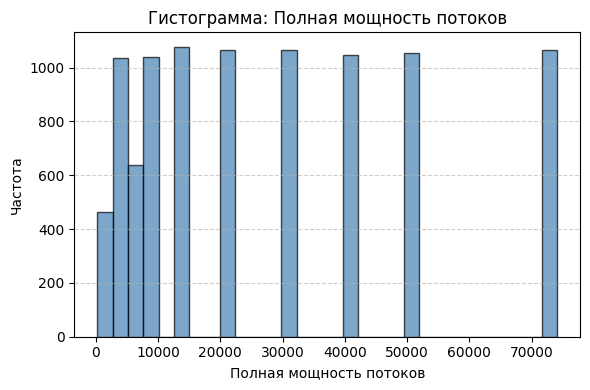

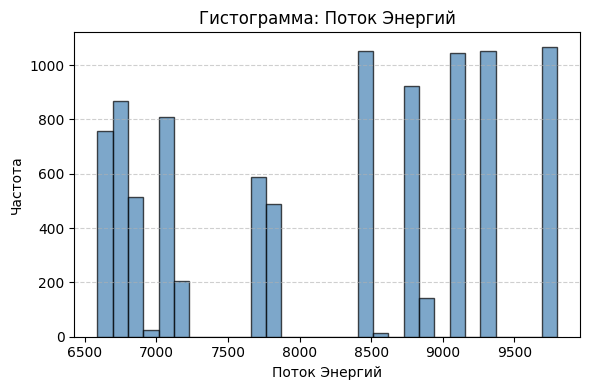

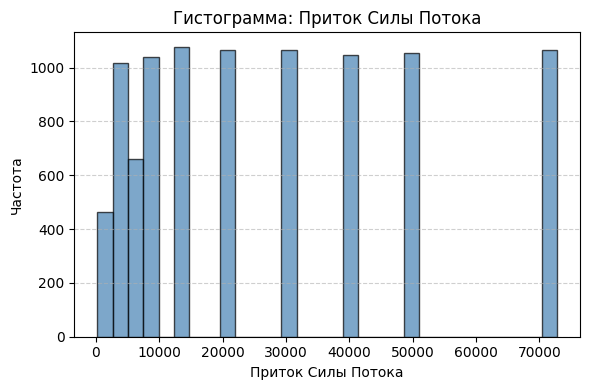

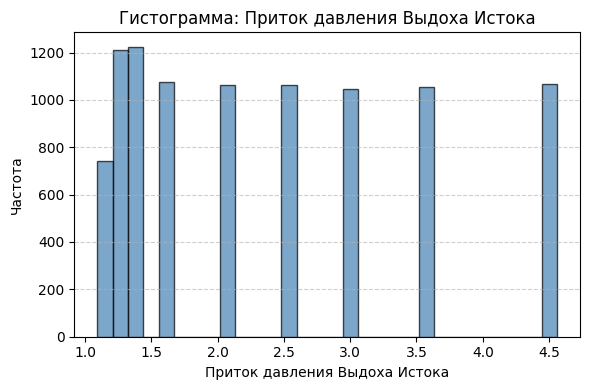

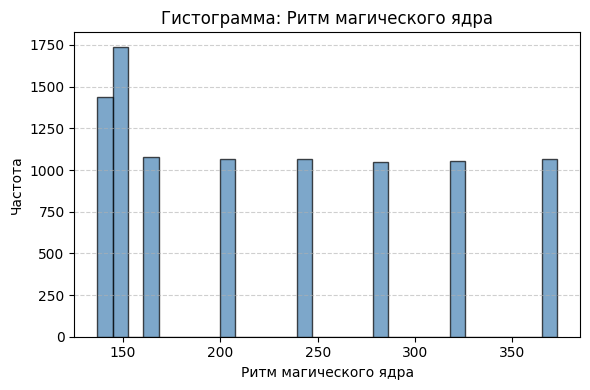

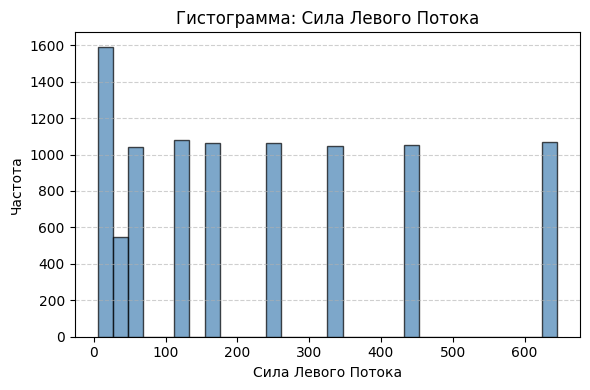

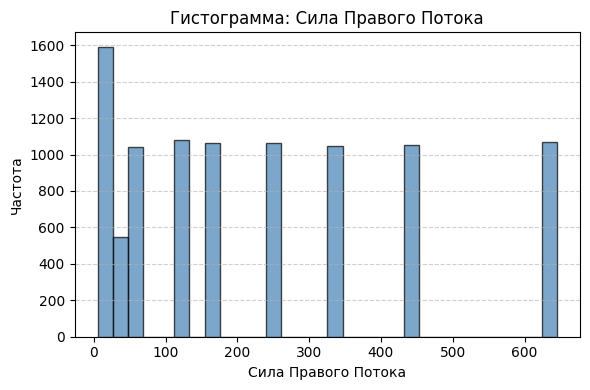

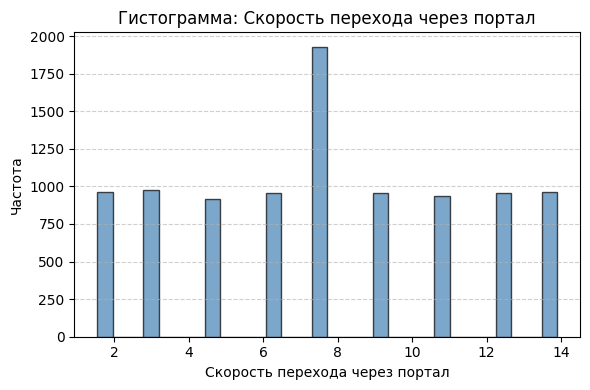

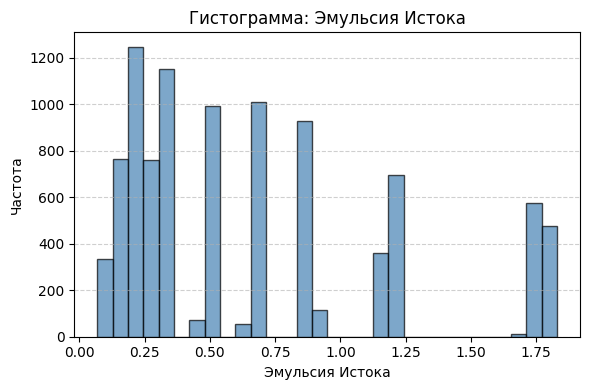

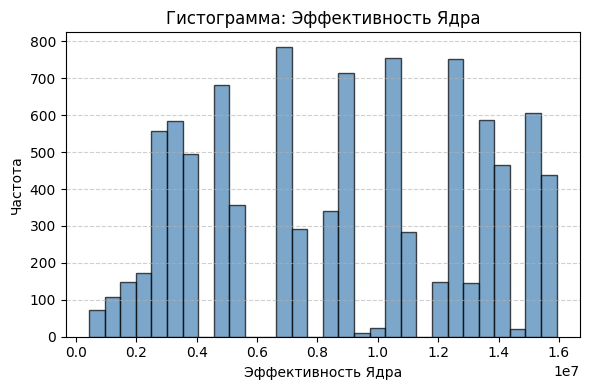

In [665]:
for col in cols_to_plot:
    plt.figure(figsize=(6, 4))
    plt.hist(combined_train_data[col].dropna(), bins=30, color='steelblue', edgecolor='black', alpha=0.7)
    plt.title(f'Гистограмма: {col}')
    plt.xlabel(col)
    plt.ylabel('Частота')
    plt.grid(True, axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

Заметим, что в некоторых гистограммах есть несколько мод (пик), что может означать наличие скрытых подгрупп.

In [666]:
print(combined_train_data.columns)

Index(['Вектор Мощи', 'Скорость перехода через портал', 'Приток Силы Потока',
       'Ритм магического ядра', 'Поток Энергий', 'Сила Левого Потока',
       'Сила Правого Потока', 'Пламя Стихий', 'Приток давления Выдоха Истока',
       'Давление выдоха Истока', 'Печать Чародея', 'Эмульсия Истока',
       'Дыхание Истока', 'Тип Вектора Мощи_Ниже среднего',
       'Тип Вектора Мощи_Сильный', 'Тип Вектора Мощи_Слабый',
       'Общая мощность потоков', 'Полная мощность потоков', 'Общая сила Ядра',
       'Общее давление на выходе', 'Эффективность Ядра',
       'Магическая производительность', 'Гармония Бессмертия'],
      dtype='object')


## 7. Удаление выбросов

В признаках 'Печать Чародея', 'Общая сила Ядра', 'Магическая производительность' присутствуют возможные выбросы. Поэтому в них имеет смысл использовать IQR или Robust Z-score.

In [667]:
columns = ['Печать Чародея', 'Общая сила Ядра', 'Магическая производительность']

In [668]:
combined_train_data_outliers = pd.DataFrame(columns=combined_train_data.columns)
for column in columns:
    Q1 = combined_train_data[column].quantile(0.25)
    Q3 = combined_train_data[column].quantile(0.75)
    IQR = Q3 - Q1

    # Границы выбросов
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # только выбросы
    combined_train_data_outliers = pd.concat([combined_train_data_outliers, combined_train_data[(combined_train_data[column] < lower_bound) | (combined_train_data[column] > upper_bound)]])

C:\Users\Gleb\AppData\Local\Temp\ipykernel_48816\1628806345.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_train_data_outliers = pd.concat([combined_train_data_outliers, combined_train_data[(combined_train_data[column] < lower_bound) | (combined_train_data[column] > upper_bound)]])


In [669]:
combined_train_data_outliers

,Вектор Мощи,Скорость перехода через портал,Приток Силы Потока,Ритм магического ядра,Поток Энергий,Сила Левого Потока,Сила Правого Потока,Пламя Стихий,Приток давления Выдоха Истока,Давление выдоха Истока,...,Тип Вектора Мощи_Ниже среднего,Тип Вектора Мощи_Сильный,Тип Вектора Мощи_Слабый,Общая мощность потоков,Полная мощность потоков,Общая сила Ядра,Общее давление на выходе,Эффективность Ядра,Магическая производительность,Гармония Бессмертия
2213,9.300,13.88988,72770.796875,372.846313,9776.623047,644.765015,644.765015,1095.430054,4.495,22.569000,...,0,1,0,1289.530029,74060.328125,2.713232e+07,27.063999,15115501.0,7.738095,0.986
5624,9.300,13.88988,72759.257812,372.841705,9750.017578,644.692993,644.692993,1088.170044,4.527,22.968000,...,0,1,0,1289.385986,74048.640625,2.712769e+07,27.495001,15112917.0,7.738095,0.975
179,9.300,13.88988,72777.296875,372.848724,9792.862305,645.143005,645.143005,1098.999023,4.474,22.297001,...,0,1,0,1290.286011,74067.585938,2.713492e+07,26.771000,15133811.0,7.746727,0.994
2879,9.300,7.71660,72767.078125,372.845062,9769.984375,644.958984,644.958984,1095.503052,4.504,22.697001,...,0,1,0,1289.917969,74057.000000,2.713085e+07,27.201000,15081070.0,4.289383,0.982
1043,9.300,13.88988,72771.406250,372.846527,9782.387695,644.776978,644.776978,1101.255981,4.489,22.537001,...,0,1,0,1289.553955,74060.960938,2.713257e+07,27.026001,15048567.0,7.703761,0.986
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4178,3.144,7.71660,8379.373047,145.221069,7129.289062,60.363998,60.363998,580.416016,1.388,7.422000,...,1,0,0,120.727997,8500.100586,1.216862e+06,8.809999,5091471.0,32.287029,0.997
9613,2.088,7.71660,4945.750977,146.095779,6755.585938,31.648001,31.648001,553.757019,1.279,6.945000,...,0,0,1,63.296001,5009.046875,7.225533e+05,8.224000,3823033.5,40.828571,0.977
9470,3.144,7.71660,8375.512695,145.218765,7052.375977,60.306000,60.306000,578.177979,1.392,7.505000,...,1,0,0,120.612000,8496.125000,1.216282e+06,8.897000,5110427.0,32.422688,0.987
8397,1.138,7.71660,2352.278076,147.339127,6698.549805,10.766000,10.766000,494.427002,1.184,6.301000,...,0,0,1,21.532000,2373.810059,3.465826e+05,7.485000,2795021.0,62.230644,0.998


Теперь воспользуемся robust z-score

In [670]:
def robust_zscore(series):
    median = series.median()
    mad = np.median(np.abs(series - median))
    # Защита от деления на ноль:
    if mad == 0:
        return pd.Series([0.0] * len(series), index=series.index)
    return (series - median) / mad

In [671]:
THRESHOLD = 3.5

In [672]:
combined_train_data_outliers_z_score = pd.DataFrame(columns=combined_train_data.columns)
for column in columns:
    rz = robust_zscore(combined_train_data[column])
    mask = np.abs(rz) > THRESHOLD

    outliers = combined_train_data[mask].index  # ← сохраняем!
    combined_train_data_outliers_z_score = pd.concat([combined_train_data_outliers_z_score, combined_train_data.loc[outliers]])

C:\Users\Gleb\AppData\Local\Temp\ipykernel_48816\1144483877.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_train_data_outliers_z_score = pd.concat([combined_train_data_outliers_z_score, combined_train_data.loc[outliers]])


In [673]:
combined_train_data_outliers_z_score

,Вектор Мощи,Скорость перехода через портал,Приток Силы Потока,Ритм магического ядра,Поток Энергий,Сила Левого Потока,Сила Правого Потока,Пламя Стихий,Приток давления Выдоха Истока,Давление выдоха Истока,...,Тип Вектора Мощи_Ниже среднего,Тип Вектора Мощи_Сильный,Тип Вектора Мощи_Слабый,Общая мощность потоков,Полная мощность потоков,Общая сила Ядра,Общее давление на выходе,Эффективность Ядра,Магическая производительность,Гармония Бессмертия
11258,9.300,7.71660,72755.132812,372.839294,9724.115234,644.809021,644.809021,1060.384033,4.555,23.070999,...,0,1,0,1289.618042,74044.750000,2.712597e+07,27.625999,15465207.0,4.399430,0.977
1844,9.300,13.88988,72780.218750,372.847870,9787.174805,644.872009,644.872009,1088.225952,4.480,22.263000,...,0,1,0,1289.744019,74069.960938,2.713595e+07,26.743000,15279251.0,7.820879,0.997
9044,9.300,13.88988,72770.484375,372.843689,9748.215820,644.797974,644.797974,1058.765015,4.526,22.625000,...,0,1,0,1289.595947,74060.078125,2.713202e+07,27.151001,15593113.0,7.982690,0.991
10601,9.300,13.88988,72761.296875,372.840546,9732.306641,644.838013,644.838013,1059.115967,4.545,22.914000,...,0,1,0,1289.676025,74050.976562,2.712836e+07,27.459000,15519658.0,7.946156,0.982
2213,9.300,13.88988,72770.796875,372.846313,9776.623047,644.765015,644.765015,1095.430054,4.495,22.569000,...,0,1,0,1289.530029,74060.328125,2.713232e+07,27.063999,15115501.0,7.738095,0.986
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4178,3.144,7.71660,8379.373047,145.221069,7129.289062,60.363998,60.363998,580.416016,1.388,7.422000,...,1,0,0,120.727997,8500.100586,1.216862e+06,8.809999,5091471.0,32.287029,0.997
9613,2.088,7.71660,4945.750977,146.095779,6755.585938,31.648001,31.648001,553.757019,1.279,6.945000,...,0,0,1,63.296001,5009.046875,7.225533e+05,8.224000,3823033.5,40.828571,0.977
9470,3.144,7.71660,8375.512695,145.218765,7052.375977,60.306000,60.306000,578.177979,1.392,7.505000,...,1,0,0,120.612000,8496.125000,1.216282e+06,8.897000,5110427.0,32.422688,0.987
8397,1.138,7.71660,2352.278076,147.339127,6698.549805,10.766000,10.766000,494.427002,1.184,6.301000,...,0,0,1,21.532000,2373.810059,3.465826e+05,7.485000,2795021.0,62.230644,0.998


Особой разницы между различными значениями THRESHOLD нет (2419 для 4.5 и 2446 для 3.5). Поэтому используем 3.5 

In [674]:
intersection = combined_train_data_outliers_z_score.merge(combined_train_data_outliers, how="inner")
intersection = intersection.drop_duplicates().reset_index(drop=True)

In [675]:
intersection

,Вектор Мощи,Скорость перехода через портал,Приток Силы Потока,Ритм магического ядра,Поток Энергий,Сила Левого Потока,Сила Правого Потока,Пламя Стихий,Приток давления Выдоха Истока,Давление выдоха Истока,...,Тип Вектора Мощи_Ниже среднего,Тип Вектора Мощи_Сильный,Тип Вектора Мощи_Слабый,Общая мощность потоков,Полная мощность потоков,Общая сила Ядра,Общее давление на выходе,Эффективность Ядра,Магическая производительность,Гармония Бессмертия
0,9.300,7.71660,72755.132812,372.839294,9724.115234,644.809021,644.809021,1060.384033,4.555,23.070999,...,0,1,0,1289.618042,74044.750000,2.712597e+07,27.625999,15465207.0,4.399430,0.977
1,9.300,13.88988,72780.218750,372.847870,9787.174805,644.872009,644.872009,1088.225952,4.480,22.263000,...,0,1,0,1289.744019,74069.960938,2.713595e+07,26.743000,15279251.0,7.820879,0.997
2,9.300,13.88988,72770.484375,372.843689,9748.215820,644.797974,644.797974,1058.765015,4.526,22.625000,...,0,1,0,1289.595947,74060.078125,2.713202e+07,27.151001,15593113.0,7.982690,0.991
3,9.300,13.88988,72761.296875,372.840546,9732.306641,644.838013,644.838013,1059.115967,4.545,22.914000,...,0,1,0,1289.676025,74050.976562,2.712836e+07,27.459000,15519658.0,7.946156,0.982
4,9.300,13.88988,72770.796875,372.846313,9776.623047,644.765015,644.765015,1095.430054,4.495,22.569000,...,0,1,0,1289.530029,74060.328125,2.713232e+07,27.063999,15115501.0,7.738095,0.986
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1344,3.144,7.71660,8379.373047,145.221069,7129.289062,60.363998,60.363998,580.416016,1.388,7.422000,...,1,0,0,120.727997,8500.100586,1.216862e+06,8.809999,5091471.0,32.287029,0.997
1345,2.088,7.71660,4945.750977,146.095779,6755.585938,31.648001,31.648001,553.757019,1.279,6.945000,...,0,0,1,63.296001,5009.046875,7.225533e+05,8.224000,3823033.5,40.828571,0.977
1346,3.144,7.71660,8375.512695,145.218765,7052.375977,60.306000,60.306000,578.177979,1.392,7.505000,...,1,0,0,120.612000,8496.125000,1.216282e+06,8.897000,5110427.0,32.422688,0.987
1347,1.138,7.71660,2352.278076,147.339127,6698.549805,10.766000,10.766000,494.427002,1.184,6.301000,...,0,0,1,21.532000,2373.810059,3.465826e+05,7.485000,2795021.0,62.230644,0.998


Вот и есть выбросы, которые мы удалим из train выборки.

In [676]:
combined_train_data

,Вектор Мощи,Скорость перехода через портал,Приток Силы Потока,Ритм магического ядра,Поток Энергий,Сила Левого Потока,Сила Правого Потока,Пламя Стихий,Приток давления Выдоха Истока,Давление выдоха Истока,...,Тип Вектора Мощи_Ниже среднего,Тип Вектора Мощи_Сильный,Тип Вектора Мощи_Слабый,Общая мощность потоков,Полная мощность потоков,Общая сила Ядра,Общее давление на выходе,Эффективность Ядра,Магическая производительность,Гармония Бессмертия
1996,8.206,12.34656,50996.140625,323.331451,9318.402344,438.010986,438.010986,933.244019,3.571,18.382999,...,0,1,0,876.021973,51872.164062,1.648866e+07,21.953999,13683531.0,10.246107,0.988
11259,1.138,7.71660,3446.263916,142.667679,6597.133789,8.212000,8.212000,546.807007,1.217,6.622000,...,0,0,1,16.424000,3462.687988,4.916705e+05,7.839000,2574191.0,40.401047,0.978
5614,8.206,12.34656,50993.601562,323.322021,9314.871094,438.087006,438.087006,910.711975,3.573,18.193001,...,0,1,0,876.174011,51869.777344,1.648735e+07,21.766001,14091756.0,10.552615,1.000
3604,5.140,7.71660,21633.392578,201.514847,8489.322266,175.306000,175.306000,713.585999,2.080,11.105000,...,0,0,0,350.612000,21984.003906,4.359450e+06,13.184999,8649702.0,15.310714,0.985
7288,8.206,12.34656,50991.355469,323.307892,9301.239258,438.071014,438.071014,928.221985,3.596,18.674000,...,0,1,0,876.142029,51867.496094,1.648591e+07,22.270000,13669907.0,10.237612,0.978
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3046,5.140,7.71660,21632.289062,201.513168,8482.175781,175.251999,175.251999,724.460999,2.083,11.217000,...,0,0,0,350.503998,21982.792969,4.359191e+06,13.300000,8448045.0,14.954652,0.975
9917,9.300,13.88988,72763.460938,372.842224,9737.532227,644.765015,644.765015,1060.546997,4.539,22.840000,...,0,1,0,1289.530029,74052.992188,2.712929e+07,27.379000,15511315.0,7.941613,0.984
4079,3.144,4.62996,8378.214844,145.220337,7101.082031,60.342999,60.342999,589.155029,1.389,7.501000,...,1,0,0,120.685997,8498.900391,1.216687e+06,8.890000,4945882.5,18.820976,0.986
2254,5.140,7.71660,21636.271484,201.516098,8500.585938,175.283005,175.283005,710.984985,2.077,11.028000,...,0,0,0,350.566010,21986.837891,4.360057e+06,13.105000,8720114.0,15.433200,0.991


In [677]:
clean = combined_train_data.merge(
    intersection,
    how='outer',
    indicator=True
).query('_merge == "left_only"').drop(columns='_merge')

In [678]:
clean

,Вектор Мощи,Скорость перехода через портал,Приток Силы Потока,Ритм магического ядра,Поток Энергий,Сила Левого Потока,Сила Правого Потока,Пламя Стихий,Приток давления Выдоха Истока,Давление выдоха Истока,...,Тип Вектора Мощи_Ниже среднего,Тип Вектора Мощи_Сильный,Тип Вектора Мощи_Слабый,Общая мощность потоков,Полная мощность потоков,Общая сила Ядра,Общее давление на выходе,Эффективность Ядра,Магическая производительность,Гармония Бессмертия
0,1.138,1.54332,253.546997,140.286255,6717.352051,7.000000,7.000000,453.570007,1.093,5.832,...,0,0,1,14.000000,267.546997,3.556916e+04,6.925000,4.560149e+05,19.786152,0.995
1,1.138,1.54332,268.738007,139.929779,6712.894043,6.807000,6.807000,455.614014,1.093,5.836,...,0,0,1,13.614000,282.352020,3.760445e+04,6.929000,4.585908e+05,18.820974,0.995
2,1.138,1.54332,276.699005,140.670883,6715.466797,7.191000,7.191000,450.600006,1.094,5.831,...,0,0,1,14.382000,291.080994,3.892349e+04,6.925000,5.259931e+05,20.855675,0.996
3,1.138,1.54332,283.855011,140.221954,6666.292969,6.993000,6.993000,467.709015,1.095,5.942,...,0,0,1,13.986000,297.841003,3.980270e+04,7.037000,4.373923e+05,16.959560,0.976
4,1.138,1.54332,284.459015,140.810577,6670.308105,7.296000,7.296000,463.601013,1.095,5.935,...,0,0,1,14.592000,299.051025,4.005484e+04,7.030000,4.768433e+05,18.372856,0.977
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8475,8.206,12.34656,50997.937500,323.336273,9320.509766,438.131012,438.131012,944.156006,3.571,18.486,...,0,1,0,876.262024,51874.199219,1.648948e+07,22.056999,1.349385e+07,10.103567,0.982
8476,8.206,12.34656,50997.941406,323.336273,9321.484375,438.003998,438.003998,943.809021,3.569,18.461,...,0,1,0,876.007996,51873.949219,1.648948e+07,22.030001,1.350490e+07,10.111843,0.983
8477,8.206,12.34656,50998.039062,323.336578,9321.125977,438.031006,438.031006,944.838013,3.570,18.482,...,0,1,0,876.062012,51874.101562,1.648953e+07,22.052000,1.348285e+07,10.095305,0.982
8478,8.206,12.34656,50998.050781,323.336273,9320.404297,438.003998,438.003998,946.906006,3.572,18.525,...,0,1,0,876.007996,51874.058594,1.648952e+07,22.097000,1.344985e+07,10.070603,0.980


## 8. Удаление аномалий

Теперь будем искать аномалии с помощью Isolation Forest, One-class SVM и DBSCAN

Взял визуализацию из примера*

In [679]:
def draw_anomaly(X_2d: np.ndarray[float], anomaly_mask: np.ndarray[bool]) -> None:
    """Визуализация аномальных объектов

    Args:
        X_2d (np.ndarray[float]): Датасет, пониженный до двумерного пространства
        anomaly_mask (np.ndarray[bool]): Маска аномальных объектов
    """
    plt.scatter(X_2d[:, 0], X_2d[:, 1])
    plt.scatter(X_2d[anomaly_mask, 0], X_2d[anomaly_mask, 1], c="red", marker='x')

In [680]:
def draw_anomaly_pie(anomaly_mask: np.ndarray[bool]) -> None:
    """Визуализация долей аномальных и неаномальных объектов в данных

    Args:
        anomaly_mask (np.ndarray[bool]): Маска аномальных объектов
    """
    _, counts = np.unique(anomaly_mask, return_counts=True)

    plt.pie(counts, labels=counts, autopct='%1.0f%%');
    plt.legend([
        'Нормальные объекты', 'Аномалии'
    ], loc='lower right');

### Isolation forest

Поскольку точной информации о том, что же является аномалией, что нет - то берем contamination (ожидаемая доля аномалий) равным 0,1. 

In [681]:
feature_cols = clean.columns.drop('Гармония Бессмертия')
train = clean[feature_cols].values

In [682]:
iso_forest = IsolationForest(
    contamination=0.1,
    random_state=42,
    n_estimators=100
)

In [683]:
predicted_iso = iso_forest.fit_predict(train)

In [684]:
anomaly = (predicted_iso == 1)

In [685]:
anomalies_iso = clean[anomaly].copy()

Для визуализации уменьшим размерность до 2-х. Используем PCA.

In [686]:
pca = PCA(n_components=2, random_state=42)
train_2d = pca.fit_transform(train)

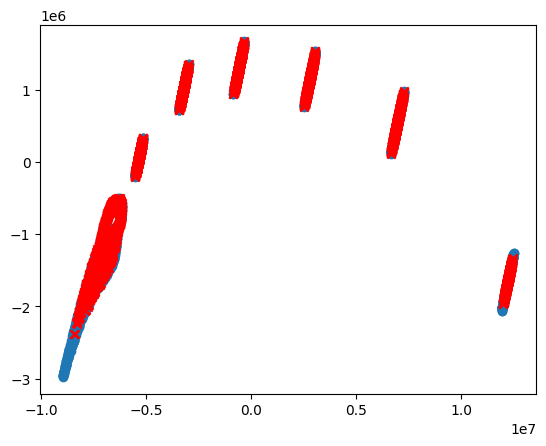

In [687]:
draw_anomaly(train_2d, anomaly)

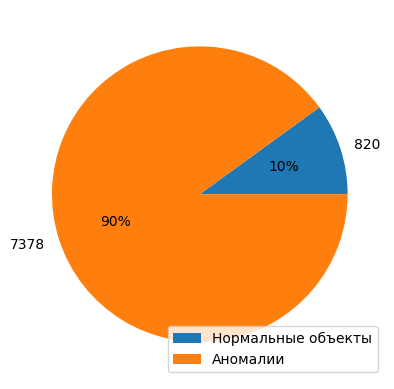

In [688]:
draw_anomaly_pie(anomaly)

Получаем 955 аномалий.

### One-class SVM

In [689]:
ocsvm = OCSVM(
    kernel='rbf', # хорошо обрабатывает нелинейные связи
    nu=0.1, # верхняя оценка на долю ошибок границы и опорных векторов
)

ocsvm1 = OCSVM(
    kernel='rbf', # хорошо обрабатывает нелинейные связи
    nu=0.1, # верхняя оценка на долю ошибок границы и опорных векторов
)

ocsvm2 = OCSVM(
    kernel='rbf', # хорошо обрабатывает нелинейные связи
    nu=0.1, # верхняя оценка на долю ошибок границы и опорных векторов
)

Сделаем стандартизацию (2-мя способами)

In [690]:
scaler_std = StandardScaler()
train_std = scaler_std.fit_transform(train)

In [691]:
scaler_robust = RobustScaler()
train_robust = scaler_robust.fit_transform(train)

In [692]:
ocsvm1.fit(train_std)

OCSVM(cache_size=200, coef0=0.0, contamination=0.1, degree=3, gamma='auto',
   kernel='rbf', max_iter=-1, nu=0.1, shrinking=True, tol=0.001,
   verbose=False)

In [693]:
ocsvm2.fit(train_robust)

OCSVM(cache_size=200, coef0=0.0, contamination=0.1, degree=3, gamma='auto',
   kernel='rbf', max_iter=-1, nu=0.1, shrinking=True, tol=0.001,
   verbose=False)

In [694]:
predicted_ocsvm1 = ocsvm1.labels_
predicted_ocsvm2 = ocsvm2.labels_

In [695]:
anomaly_ocsvm1 = (predicted_ocsvm1 == 1)
anomaly_ocsvm2 = (predicted_ocsvm2 == 1)

In [696]:
anomalies_ocsvm1 = clean[anomaly_ocsvm1].copy()
anomalies_ocsvm2 = clean[anomaly_ocsvm2].copy()

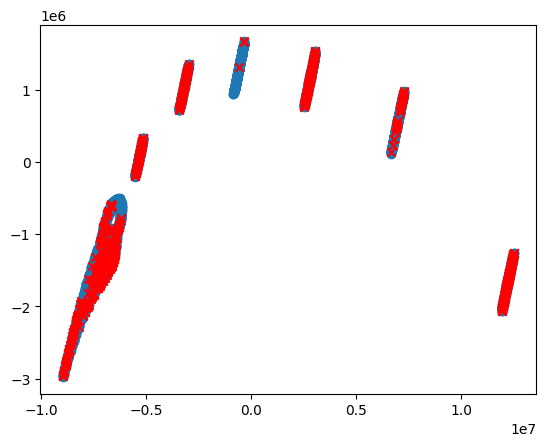

In [697]:
draw_anomaly(train_2d, anomaly_ocsvm1)

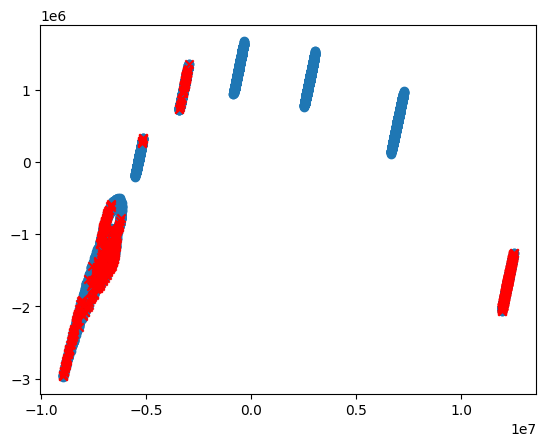

In [698]:
draw_anomaly(train_2d, anomaly_ocsvm2)

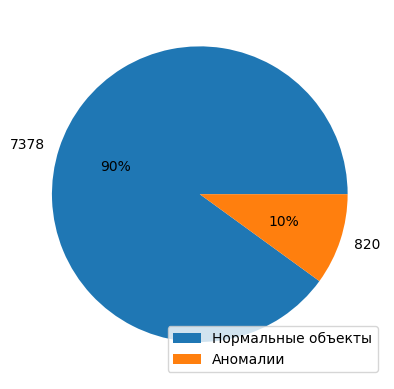

In [699]:
draw_anomaly_pie(anomaly_ocsvm1)

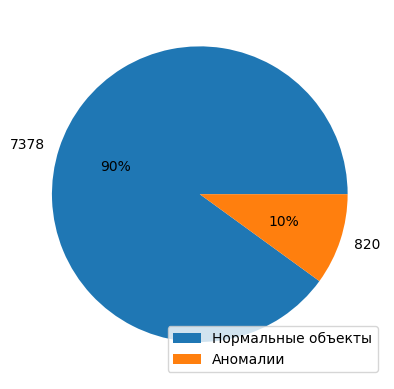

In [700]:
draw_anomaly_pie(anomaly_ocsvm2)

Заметим, что при разных стандартизациях - разные результаты. Поэтому возьмем их пересечение

In [701]:
intersection = anomaly_ocsvm1 & anomaly_ocsvm2
anomalies_intersection = clean[intersection]

In [702]:
anomalies_intersection

,Вектор Мощи,Скорость перехода через портал,Приток Силы Потока,Ритм магического ядра,Поток Энергий,Сила Левого Потока,Сила Правого Потока,Пламя Стихий,Приток давления Выдоха Истока,Давление выдоха Истока,...,Тип Вектора Мощи_Ниже среднего,Тип Вектора Мощи_Сильный,Тип Вектора Мощи_Слабый,Общая мощность потоков,Полная мощность потоков,Общая сила Ядра,Общее давление на выходе,Эффективность Ядра,Магическая производительность,Гармония Бессмертия
0,1.138,1.54332,253.546997,140.286255,6717.352051,7.000000,7.000000,453.570007,1.093,5.832,...,0,0,1,14.000000,267.546997,3.556916e+04,6.925000,4.560149e+05,19.786152,0.995
1,1.138,1.54332,268.738007,139.929779,6712.894043,6.807000,6.807000,455.614014,1.093,5.836,...,0,0,1,13.614000,282.352020,3.760445e+04,6.929000,4.585908e+05,18.820974,0.995
2,1.138,1.54332,276.699005,140.670883,6715.466797,7.191000,7.191000,450.600006,1.094,5.831,...,0,0,1,14.382000,291.080994,3.892349e+04,6.925000,5.259931e+05,20.855675,0.996
4,1.138,1.54332,284.459015,140.810577,6670.308105,7.296000,7.296000,463.601013,1.095,5.935,...,0,0,1,14.592000,299.051025,4.005484e+04,7.030000,4.768433e+05,18.372856,0.977
5,1.138,1.54332,290.028992,140.650253,6713.084961,7.178000,7.178000,450.910004,1.095,5.834,...,0,0,1,14.356000,304.384979,4.079265e+04,6.929000,5.439020e+05,20.577599,0.996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8475,8.206,12.34656,50997.937500,323.336273,9320.509766,438.131012,438.131012,944.156006,3.571,18.486,...,0,1,0,876.262024,51874.199219,1.648948e+07,22.056999,1.349385e+07,10.103567,0.982
8476,8.206,12.34656,50997.941406,323.336273,9321.484375,438.003998,438.003998,943.809021,3.569,18.461,...,0,1,0,876.007996,51873.949219,1.648948e+07,22.030001,1.350490e+07,10.111843,0.983
8477,8.206,12.34656,50998.039062,323.336578,9321.125977,438.031006,438.031006,944.838013,3.570,18.482,...,0,1,0,876.062012,51874.101562,1.648953e+07,22.052000,1.348285e+07,10.095305,0.982
8478,8.206,12.34656,50998.050781,323.336273,9320.404297,438.003998,438.003998,946.906006,3.572,18.525,...,0,1,0,876.007996,51874.058594,1.648952e+07,22.097000,1.344985e+07,10.070603,0.980


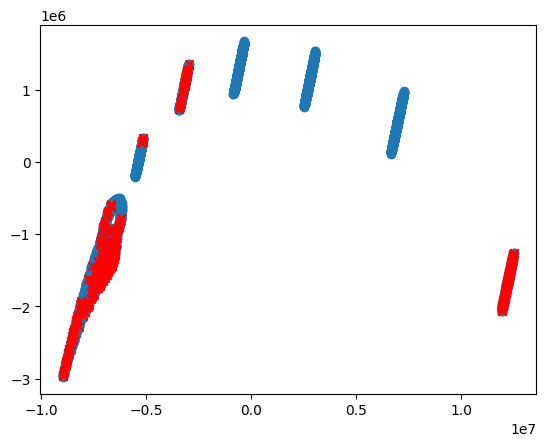

In [703]:
draw_anomaly(train_2d, intersection)

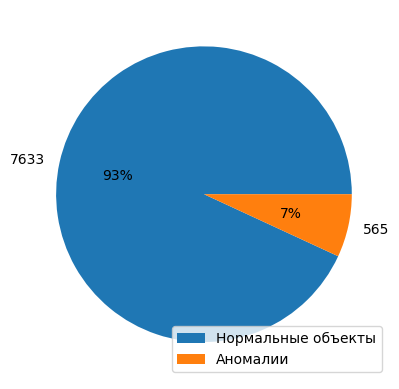

In [704]:
draw_anomaly_pie(intersection)

В пересечении получаем 729 строки

### DBSCAN

В качестве eps будем использовать среднее расстояние между точкой и её ближайшим 4-ым соседом. 

In [705]:
eps_std = np.mean(
    NearestNeighbors(n_neighbors=5)
    .fit(train_std)
    .kneighbors()[0][:, -1]
)

In [706]:
eps_robust = np.mean(
    NearestNeighbors(n_neighbors=5)
    .fit(train_robust)
    .kneighbors()[0][:, -1]
)

In [707]:
dbscan_std = DBSCAN(eps=eps_std, min_samples=5, n_jobs=-1)
dbscan_robust = DBSCAN(eps=eps_robust, min_samples=5, n_jobs=-1)

In [708]:
anomaly_dbscan_std = (dbscan_std.fit_predict(train_std) == -1)
anomaly_dbscan_robust = (dbscan_robust.fit_predict(train_robust) == -1)

In [709]:
anomalies_dbscan_std = clean[anomaly_dbscan_std].copy()
anomalies_dbscan_robust = clean[anomaly_dbscan_robust].copy()

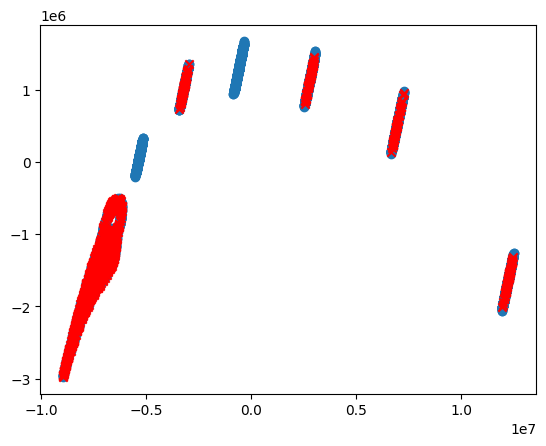

In [710]:
draw_anomaly(train_2d, anomaly_dbscan_std)

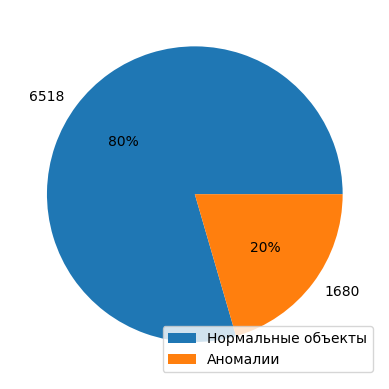

In [711]:
draw_anomaly_pie(anomaly_dbscan_std)

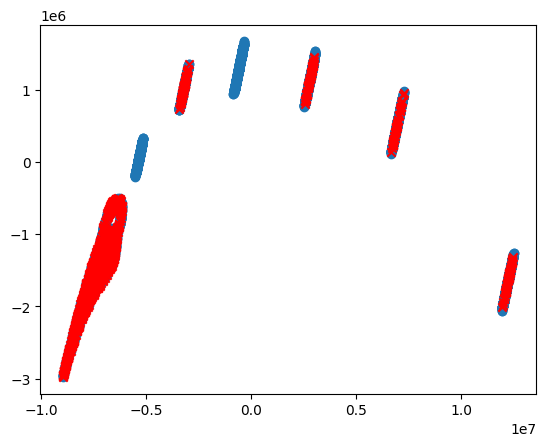

In [712]:
draw_anomaly(train_2d, anomaly_dbscan_robust)

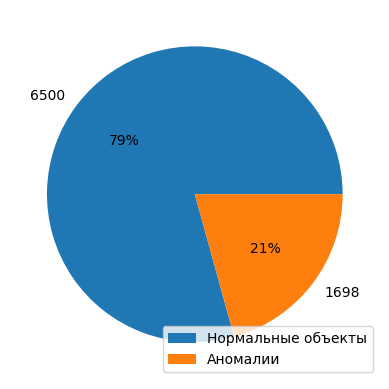

In [713]:
draw_anomaly_pie(anomaly_dbscan_robust)

In [714]:
intersection_check = anomaly_dbscan_std & anomaly_dbscan_robust

In [715]:
anomalies_intersection = clean[intersection_check].copy()

In [716]:
anomalies_intersection

,Вектор Мощи,Скорость перехода через портал,Приток Силы Потока,Ритм магического ядра,Поток Энергий,Сила Левого Потока,Сила Правого Потока,Пламя Стихий,Приток давления Выдоха Истока,Давление выдоха Истока,...,Тип Вектора Мощи_Ниже среднего,Тип Вектора Мощи_Сильный,Тип Вектора Мощи_Слабый,Общая мощность потоков,Полная мощность потоков,Общая сила Ядра,Общее давление на выходе,Эффективность Ядра,Магическая производительность,Гармония Бессмертия
0,1.138,1.54332,253.546997,140.286255,6717.352051,7.000000,7.000000,453.570007,1.093,5.832000,...,0,0,1,14.000000,267.546997,3.556916e+04,6.925000,4.560149e+05,19.786152,0.995
1,1.138,1.54332,268.738007,139.929779,6712.894043,6.807000,6.807000,455.614014,1.093,5.836000,...,0,0,1,13.614000,282.352020,3.760445e+04,6.929000,4.585908e+05,18.820974,0.995
2,1.138,1.54332,276.699005,140.670883,6715.466797,7.191000,7.191000,450.600006,1.094,5.831000,...,0,0,1,14.382000,291.080994,3.892349e+04,6.925000,5.259931e+05,20.855675,0.996
3,1.138,1.54332,283.855011,140.221954,6666.292969,6.993000,6.993000,467.709015,1.095,5.942000,...,0,0,1,13.986000,297.841003,3.980270e+04,7.037000,4.373923e+05,16.959560,0.976
4,1.138,1.54332,284.459015,140.810577,6670.308105,7.296000,7.296000,463.601013,1.095,5.935000,...,0,0,1,14.592000,299.051025,4.005484e+04,7.030000,4.768433e+05,18.372856,0.977
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7516,8.206,7.71660,50996.562500,323.331970,9315.491211,438.122009,438.122009,934.304993,3.575,18.455999,...,0,1,0,876.244019,51872.804688,1.648882e+07,22.031000,1.364968e+07,6.387914,0.985
7517,8.206,7.71660,50996.761719,323.332916,9318.991211,438.122986,438.122986,933.942017,3.570,18.379000,...,0,1,0,876.245972,51873.007812,1.648893e+07,21.948999,1.367242e+07,6.398508,0.988
7518,8.206,7.71660,50996.910156,323.333771,9321.174805,438.128998,438.128998,934.963013,3.567,18.348000,...,0,1,0,876.257996,51873.167969,1.648902e+07,21.914999,1.367249e+07,6.398508,0.989
7519,8.206,7.71660,50997.164062,323.333984,9318.523438,437.985992,437.985992,937.677002,3.572,18.438999,...,0,1,0,875.971985,51873.136719,1.648912e+07,22.011000,1.360488e+07,6.366832,0.985


Получаем 1699 строк.

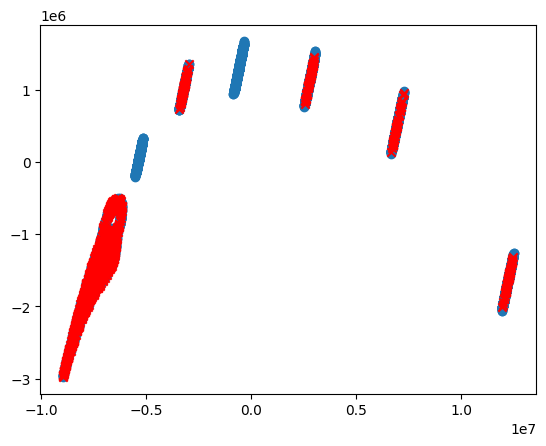

In [717]:
draw_anomaly(train_2d, intersection_check)

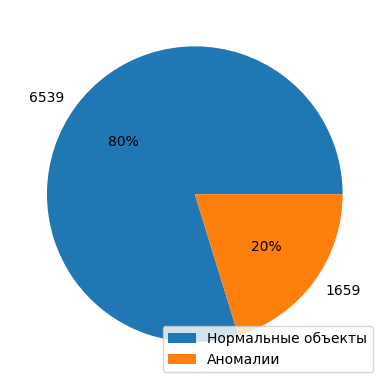

In [718]:
draw_anomaly_pie(intersection_check)

### Объединим полученные результаты

In [719]:
final_intersection = intersection_check & intersection & anomaly

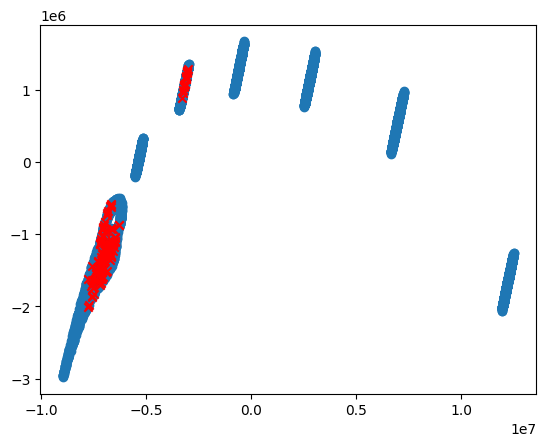

In [720]:
draw_anomaly(train_2d, final_intersection)

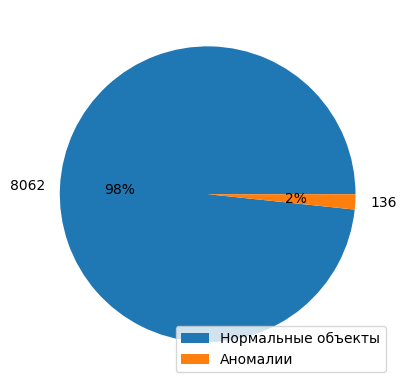

In [721]:
draw_anomaly_pie(final_intersection)

Получаем 136 аномалий - их мы и удалим

In [722]:
target_col = 'Гармония Бессмертия'

In [723]:
data_without_anomalies = clean[~final_intersection]

In [724]:
X_train_clear, y_train_clear = data_without_anomalies.drop(columns=[target_col]), data_without_anomalies[target_col]
X_train_clear

,Вектор Мощи,Скорость перехода через портал,Приток Силы Потока,Ритм магического ядра,Поток Энергий,Сила Левого Потока,Сила Правого Потока,Пламя Стихий,Приток давления Выдоха Истока,Давление выдоха Истока,...,Дыхание Истока,Тип Вектора Мощи_Ниже среднего,Тип Вектора Мощи_Сильный,Тип Вектора Мощи_Слабый,Общая мощность потоков,Полная мощность потоков,Общая сила Ядра,Общее давление на выходе,Эффективность Ядра,Магическая производительность
0,1.138,1.54332,253.546997,140.286255,6717.352051,7.000000,7.000000,453.570007,1.093,5.832,...,0.952,0,0,1,14.000000,267.546997,3.556916e+04,6.925000,4.560149e+05,19.786152
1,1.138,1.54332,268.738007,139.929779,6712.894043,6.807000,6.807000,455.614014,1.093,5.836,...,0.953,0,0,1,13.614000,282.352020,3.760445e+04,6.929000,4.585908e+05,18.820974
2,1.138,1.54332,276.699005,140.670883,6715.466797,7.191000,7.191000,450.600006,1.094,5.831,...,0.955,0,0,1,14.382000,291.080994,3.892349e+04,6.925000,5.259931e+05,20.855675
3,1.138,1.54332,283.855011,140.221954,6666.292969,6.993000,6.993000,467.709015,1.095,5.942,...,0.953,0,0,1,13.986000,297.841003,3.980270e+04,7.037000,4.373923e+05,16.959560
4,1.138,1.54332,284.459015,140.810577,6670.308105,7.296000,7.296000,463.601013,1.095,5.935,...,0.954,0,0,1,14.592000,299.051025,4.005484e+04,7.030000,4.768433e+05,18.372856
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8475,8.206,12.34656,50997.937500,323.336273,9320.509766,438.131012,438.131012,944.156006,3.571,18.486,...,0.951,0,1,0,876.262024,51874.199219,1.648948e+07,22.056999,1.349385e+07,10.103567
8476,8.206,12.34656,50997.941406,323.336273,9321.484375,438.003998,438.003998,943.809021,3.569,18.461,...,0.950,0,1,0,876.007996,51873.949219,1.648948e+07,22.030001,1.350490e+07,10.111843
8477,8.206,12.34656,50998.039062,323.336578,9321.125977,438.031006,438.031006,944.838013,3.570,18.482,...,0.950,0,1,0,876.062012,51874.101562,1.648953e+07,22.052000,1.348285e+07,10.095305
8478,8.206,12.34656,50998.050781,323.336273,9320.404297,438.003998,438.003998,946.906006,3.572,18.525,...,0.950,0,1,0,876.007996,51874.058594,1.648952e+07,22.097000,1.344985e+07,10.070603


In [725]:
y_train_clear

0       0.995
1       0.995
2       0.996
3       0.976
4       0.977
        ...  
8475    0.982
8476    0.983
8477    0.982
8478    0.980
8479    0.981
Name: Гармония Бессмертия, Length: 8062, dtype: float32

Получаем X_train_clear и y_train_clear, которые очищены и от аномалий, и от выбросов